# Scrapping twitter data 





In [ ]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [ ]:
def scrappe_tweets(query):
  scrapped_tweets = []
  limit = 10000
  for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if len(scrapped_tweets) == limit:
      break
    else:
      if tweet is not None:  # add error handling code
        scrapped_tweets.append([tweet.id,tweet.date, tweet.user.username, tweet.rawContent, tweet.replyCount, tweet.retweetCount, tweet.likeCount])
  
  return scrapped_tweets


Method contruct query - method which takes a profile from which we want to scrappe tweets and a key word which those scrapped tweets have to contain. From that it creates a query for the scrapper library

In [ ]:
def construck_query(word, profile):
  base_query = '"{}" (from:{}) until:2021-12-31 since:2009-01-01'
  return base_query.format(word, profile)

Metod mine_profile_data - method which allows for scrapping all the tweets from the specified twitter profile as long as they have at least one of the words in the word_list

In [ ]:
def mine_profile_data(word_list, profile):
  all_profile_data = []
  for word in word_list:
    query = construck_query(word,profile)
    l = scrappe_tweets(query)
    all_profile_data.extend(l)

  return all_profile_data

Method get_all_data - method which is able to get all the data from the profiles stored in profile_list as long as they contain at least one word from the word_list

In [ ]:
def get_all_data(profile_list, word_list):
  all_data = []
  for profile in profile_list:
    print('------------')
    print(profile)
    all_data.extend(mine_profile_data(word_list,profile))
  return all_data

In [ ]:
word_list = ['iphone','aapl','ipad','mac','ios','macOS','iCloud', 'apple']
profile_list = ['TechCrunch','verge','engadget','MashableTech','WIRED','CNET','Gizmodo','TechRadar','ZDNet','TheNextWeb', 'CNBC','WSJMarkets','TheStreet','MarketWatch','Stocktwits']
lista = get_all_data(profile_list, word_list)
print(len(lista))
print(lista)

------------
TechCrunch
------------
verge
------------
engadget
------------
MashableTech
------------
WIRED
------------
CNET
------------
Gizmodo
------------
TechRadar
------------
ZDNet
------------
TheNextWeb
------------
CNBC
------------
WSJMarkets
------------
TheStreet
------------
MarketWatch
------------
Stocktwits


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(len(lista))

67600


In [ ]:
print(lista[5600])

[1291423124945330180, datetime.datetime(2020, 8, 6, 17, 17, 21, tzinfo=datetime.timezone.utc), 'TechCrunch', 'macOS 11.0 Big Sur preview https://t.co/f75CYJU8KJ by @bheater', 1, 13, 44]


In [ ]:
import csv
from google.colab import drive
from datetime import datetime


# Mount Google Drive
drive.mount('/content/drive')






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_tweets_to_csv(tweets, output_file):
    unique_tweets = set(tuple(tweet) for tweet in tweets)
    unique_tweets = sorted(unique_tweets, key=lambda tweet: tweet[1])

    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['id','date', 'username', 'content','reply_count','retweet_count','like_count'])

        for tweet in unique_tweets:
            csv_writer.writerow(tweet)

In [ ]:
# Save the CSV file in your Google Drive root folder
output_file = '/content/drive/MyDrive/Dissertation/final-apple-tweets.csv'
save_tweets_to_csv(lista, output_file)

# Preprocessing

In [ ]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [ ]:
nltk.download('stopwords')
stemmer = SnowballStemmer('english')
tokenizer = TweetTokenizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_links(text):
  return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  

In [ ]:
def remove_mentions(text):
  return re.sub(r'@\w+', '',text)

In [ ]:
def tokenize(text):
  return tokenizer.tokenize(text)

In [ ]:
def remove_stopwords(text):
  stop_words = set(stopwords.words("english"))
  return [word for word in text if word not in stop_words]

In [ ]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

In [ ]:
def stemming(text):
  stemmed_words = [stemmer.stem(word) for word in text]
  stemmed_text = ' '.join(stemmed_words)
  return stemmed_text

In [ ]:
def handle_negations(tokens):
    negation = False
    result = []
    negations = {"not", "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't", "won't", "wouldn't", "don't", "doesn't", "didn't", "can't", "couldn't", "shouldn't", "mightn't", "mustn't"}
    for token in tokens:
        if token in negations:
            negation = not negation
        elif negation:
            result.append(f"not_{token}")
            negation = not negation
        else:
            result.append(token)
    return result

In [ ]:
def remove_short_words(tokens, min_length=2):
    return [token for token in tokens if len(token) >= min_length]

In [ ]:
def lowercase(text):
    return text.lower()

In [ ]:
def preprocess_version1(text):
  text = lowercase(text)
  text = remove_links(text)
  text = remove_mentions(text)
  text = remove_numbers(text)
  text = tokenize(text)
  text = remove_stopwords(text)
  tokens = handle_negations(text)
  tokens = remove_short_words(tokens)

  text = stemming(text)
  text = ' '.join(tokens)
  return text

# Exploring different sentiment analysis options

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.4 MB/s eta 0:00:00


In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd


drive.mount('/content/drive')



filename = '/content/drive/MyDrive/Dissertation/final-apple-tweets.csv'

tweets_df = pd.read_csv(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tweets_df['preprocessed'] = tweets_df['content'].apply(preprocess_version1)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


In [ ]:
sentiment_labels = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

In [ ]:
from tqdm import tqdm

def predict_sentiment(df):
    predictions = []
    for tweet in tqdm(df['content']):
        inputs = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            outputs = model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
        predicted_class = torch.argmax(outputs[0], dim=1).item()
        sentiment_label = sentiment_labels.get(predicted_class, "unknown")
        predictions.append(sentiment_label)
    return predictions

In [ ]:
tweets_df['bert_sentiment'] = predict_sentiment(tweets_df)

100%|██████████| 62827/62827 [1:16:20<00:00, 13.71it/s]


In [ ]:
output = '/content/drive/MyDrive/Dissertation/apple_feature2.csv'
tweets_df.to_csv(output, index=False)


# Feature selection

Importing the csv file which contains the tweets into a dataframe to later add new features to it

In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd



drive.mount('/content/drive')


filename = '/content/drive/MyDrive/Dissertation/final-apple-tweets.csv'

tweets_df_main = pd.read_csv(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tweets_df_main['preprocessed'] = tweets_df_main['content'].apply(preprocess_version1)

In [ ]:
tweets_df_main.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...


In [ ]:
tmp_df = tweets_df_main

# Count number of tweets by username
tweet_count_by_user = tmp_df['username'].value_counts().reset_index()

# Rename columns
tweet_count_by_user.columns = ['username', 'tweet_count']

# Display DataFrame as a table
display(tweet_count_by_user)

,username,tweet_count
0,CNET,11566
1,thenextweb,9212
2,verge,7651
3,TechCrunch,5460
4,TheStreet,5440
5,engadget,5041
6,techradar,4854
7,CNBC,4038
8,Gizmodo,3127
9,MarketWatch,2241


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon

analyzer = SentimentIntensityAnalyzer()
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

def combined_sentiment_score(text, vader_weight=0.5, lexicon_weight=0.5):

    vader_scores = analyzer.polarity_scores(text)
    vader_compound_score = vader_scores['compound']


    words = set(text.lower().split())
    positive_count = len(positive_words.intersection(words))
    negative_count = len(negative_words.intersection(words))
    word_count = len(words)

    if word_count > 0:
        lexicon_sentiment_score = (positive_count - negative_count) / word_count
    else:
        lexicon_sentiment_score = 0


    combined_score = (vader_weight * vader_compound_score) + (lexicon_weight * lexicon_sentiment_score)

    return combined_score

In [ ]:
tweets_df_main['sentiment_score']= tweets_df_main['preprocessed'].apply(combined_sentiment_score)

In [ ]:
tweets_df_main.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,sentiment_score
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-0.46025
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,0.00000
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0.12500
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,0.11315
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,-0.47980


In [ ]:
positive_count = (tweets_df_main['sentiment_score'] > 0).sum()
negative_count = (tweets_df_main['sentiment_score'] < 0).sum()
neutral_count = (tweets_df_main['sentiment_score'] == 0).sum()

# Print the results
print(f"Positive: {positive_count} tweets")
print(f"Negative: {negative_count} tweets")
print(f"Neutral: {neutral_count} tweets")

Positive: 24467 tweets
Negative: 12000 tweets
Neutral: 26360 tweets


Using BERT for the sentiment analysis 

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.6 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


In [ ]:
sentiment_labels = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

In [ ]:
from tqdm import tqdm

def predict_sentiment(df):
    predictions = []
    for tweet in tqdm(df['content']):
        inputs = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            outputs = model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
        predicted_class = torch.argmax(outputs[0], dim=1).item()
        sentiment_label = sentiment_labels.get(predicted_class, "unknown")
        predictions.append(sentiment_label)
    return predictions

In [ ]:
tweets_df['bert_sentiment'] = predict_sentiment(tweets_df)

100%|██████████| 62827/62827 [1:11:02<00:00, 14.74it/s]


In [ ]:
tweets_df.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,sentiment_score,bert_sentiment
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-0.46025,negative
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,positive
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0.12500,neutral
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,0.11315,positive
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,neutral


In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_file = '/content/drive/MyDrive/Dissertation/apple_bert.csv'
tweets_df.to_csv(output_file, index=False)

In [ ]:
filename = '/content/drive/MyDrive/Dissertation/apple_bert.csv'
tweets_df = pd.read_csv(filename)

In [ ]:
tweets_df.head()

,date,reply_count,retweet_count,like_count,preprocessed,sentiment_score,bert_sentiment,more_likes,more_retweets,is_trading_time,word_count,contains_ticker
0,2013-01-01,7,76,19,ios disturb mode fails turn new year's day,-0.46025,-1,0,1,False,16,False
1,2013-01-01,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,1,False,16,False
2,2013-01-01,3,26,40,ios apps need right,0.12500,0,1,1,True,8,False
3,2013-01-01,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,1,True,19,False
4,2013-01-01,0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,0,True,16,True


In [ ]:
tweets_df['bert_sentiment'] = tweets_df['bert_sentiment'].replace({
    'negative': -1,
    'neutral': 0,
    'positive': 1
})

In [ ]:
tweets_df.head()

,date,reply_count,retweet_count,like_count,preprocessed,sentiment_score,bert_sentiment,more_likes,more_retweets,is_trading_time,word_count,contains_ticker
0,2013-01-01,7,76,19,ios disturb mode fails turn new year's day,-0.46025,-1,0,1,False,16,False
1,2013-01-01,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,1,False,16,False
2,2013-01-01,3,26,40,ios apps need right,0.12500,0,1,1,True,8,False
3,2013-01-01,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,1,True,19,False
4,2013-01-01,0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,0,True,16,True


Add a column which checks if the tweet is influential, if it has more likes than average tweet 

In [ ]:
import numpy as np

In [ ]:
mean_like_count_all_data =  np.mean(tweets_df_main['like_count'])
print(mean_like_count_all_data)

43.38179445143012


In [ ]:
from IPython.display import display
tmp_df = tweets_df_main

In [ ]:
mean_likes_by_user = tmp_df.groupby('username')['like_count'].mean()
mean_likes_df = mean_likes_by_user.to_frame().reset_index()
mean_likes_df.columns = ['username', 'mean_like_count']
mean_likes_df = mean_likes_df.sort_values(by='mean_like_count', ascending=False)



In [ ]:
display(mean_likes_df)


,username,mean_like_count
12,verge,153.330284
7,WIRED,95.560419
9,engadget,46.304106
2,Gizmodo,46.149344
5,TechCrunch,44.611355
1,CNET,31.672142
0,CNBC,27.214710
4,Stocktwits,18.916236
11,thenextweb,13.374620
3,MarketWatch,11.760375


In [ ]:
mean_likes_by_profile = tweets_df_main.groupby('username')['like_count'].mean()

tweets_df_main['more_likes'] = tweets_df_main.apply(lambda x: 1 if x['like_count'] > mean_likes_by_profile[x['username']] else 0, axis=1)


In [ ]:
tweets_df_main.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0.12500,1
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0


In [ ]:
mean_retweets_by_profile = tweets_df_main.groupby('username')['retweet_count'].mean()

tweets_df_main['more_retweets'] = tweets_df_main.apply(lambda x : 1 if x['retweet_count'] > mean_retweets_by_profile[x['username']] else 0, axis=1)

In [ ]:
tweets_df_main.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0.12500,1,1
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0


Add a column which checks what time a day the tweet was posted, was it during trading if yes when - artice for time of day 

In [ ]:
import pytz

def convert_to_wall_street_time(date):
  series = pd.to_datetime(date)
  date_series_wallstreet = series.dt.tz_convert('US/Eastern')
  return pd.to_datetime(date_series_wallstreet)


tweets_df_main['date'] = convert_to_wall_street_time(tweets_df_main['date'])

In [ ]:
tweets_df_main.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets
0,286065651448160256,2013-01-01 06:05:40-05:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1
1,286111077647933440,2013-01-01 09:06:11-05:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1
2,286188829243748352,2013-01-01 14:15:08-05:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0.12500,1,1
3,286193218318639104,2013-01-01 14:32:35-05:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1
4,286193392310972419,2013-01-01 14:33:16-05:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0


In [ ]:
def check_if_trading_time(datetime):
  day = datetime.dayofweek

  if day >= 0 and day <= 4:
    time = datetime.hour * 60 + datetime.minute

    if time >= 570 and time <= 960:
      return True
  return False

In [ ]:
tweets_df_main['is_trading_time'] = tweets_df_main['date'].apply(check_if_trading_time)

In [ ]:
tweets_df_main.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets,is_trading_time
0,286065651448160256,2013-01-01 06:05:40-05:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1,False
1,286111077647933440,2013-01-01 09:06:11-05:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,False
2,286188829243748352,2013-01-01 14:15:08-05:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0.12500,1,1,True
3,286193218318639104,2013-01-01 14:32:35-05:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,True
4,286193392310972419,2013-01-01 14:33:16-05:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,True


Add a column with number of words in each tweet

In [ ]:
def count_words(text):
  words = text.split()
  return len(words)

tweets_df_main['word_count'] = tweets_df_main['content'].apply(count_words)

In [ ]:
tweets_df_main.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets,is_trading_time,word_count
0,286065651448160256,2013-01-01 06:05:40-05:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1,False,16
1,286111077647933440,2013-01-01 09:06:11-05:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,False,16
2,286188829243748352,2013-01-01 14:15:08-05:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0.12500,1,1,True,8
3,286193218318639104,2013-01-01 14:32:35-05:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,True,19
4,286193392310972419,2013-01-01 14:33:16-05:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,True,16


Add a column to check if a tweet contains apple stock ticker

In [ ]:
def contains_ticker(tweet):

  lower = tweet.lower()
  if 'aapl' in lower:
    return True
  return False

In [ ]:
tweets_df_main['contains_ticker'] = tweets_df_main['content'].apply(contains_ticker)

In [ ]:
tweets_df_main.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets,is_trading_time,word_count,contains_ticker
0,286065651448160256,2013-01-01 06:05:40-05:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1,False,16,False
1,286111077647933440,2013-01-01 09:06:11-05:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,False,16,False
2,286188829243748352,2013-01-01 14:15:08-05:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0.12500,1,1,True,8,False
3,286193218318639104,2013-01-01 14:32:35-05:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,True,19,False
4,286193392310972419,2013-01-01 14:33:16-05:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,True,16,True


Searching for events

In [ ]:
import datetime

event_dates = [
    datetime.date(2013, 9, 10), 
    datetime.date(2014, 6, 2), 
    datetime.date(2014, 9, 9),
    datetime.date(2015, 3, 9), 
    datetime.date(2015, 9, 9), 
    datetime.date(2016, 3, 21), 
    datetime.date(2016, 9, 7), 
    datetime.date(2017, 6, 5), 
    datetime.date(2017, 9, 12),
    datetime.date(2018, 6, 4), 
    datetime.date(2018, 9, 12), 
    datetime.date(2019, 3, 25),
    datetime.date(2019, 6, 3),
    datetime.date(2019, 9, 10),
    datetime.date(2019, 11, 12),
    datetime.date(2020, 3, 18),
    datetime.date(2020, 6, 22),
    datetime.date(2020, 9, 15),
    datetime.date(2020, 11, 10),
    datetime.date(2021, 4, 20),
    datetime.date(2021, 6, 7)
]

In [ ]:
search_terms = [    ['iphone 5s', 'iphone 5c'],
    ['ios 8', 'os x yosemite'],
    ['iphone 6', 'iphone 6 plus', 'apple watch'],
    ['apple watch'],
    ['iphone 6s', 'iphone 6s plus', 'ipad pro', 'apple tv'],
    ['iphone se', 'ipad pro'],
    ['iphone 7', 'iphone 7 plus', 'apple watch series 2'],
    ['ios 11', 'macos high sierra', 'imac', 'macbook'],
    ['iphone 8', 'iphone x', 'apple watch series 3', 'apple tv 4k'],
    ['ios 12', 'macos mojave', 'macbook', 'imac'],
    ['iphone xs', 'iphone xr', 'apple watch series 4'],
    ['apple news+', 'apple tv+', 'apple arcade'],
    ['ios 13', 'macos catalina', 'mac pro', 'pro display xdr'],
    ['iphone 11', 'iphone 11 pro', 'iphone 11 pro max', 'apple watch series 5'],
    ['16-inch macbook pro'],
    ['ipad pro', 'macbook air'],
    ['ios 14', 'macos big sur', 'imac', 'macbook pro'],
    ['apple watch series 6', 'apple watch se', 'ipad air', 'ipad 8th generation'],
    ['m1 chip'],
    ['imac', 'ipad pro', 'apple tv 4k'],
    ['ios 15', 'macos monterey', 'macbook pro', 'imac']
]

In [ ]:
from datetime import timedelta
time_window = timedelta(days=7)

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import pytz

In [ ]:
tweets_df_main['date'] = pd.to_datetime(tweets_df_main['date']).dt.date

In [ ]:
tweets_df_main.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets,is_trading_time,word_count,contains_ticker
0,286065651448160256,2013-01-01,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1,False,16,False
1,286111077647933440,2013-01-01,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,False,16,False
2,286188829243748352,2013-01-01,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0.12500,1,1,True,8,False
3,286193218318639104,2013-01-01,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,True,19,False
4,286193392310972419,2013-01-01,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,True,16,True


In [ ]:
event_dict = {}

for i, event_date in enumerate(event_dates):
   
    event_dict[event_date] = search_terms[i]

In [ ]:
from datetime import datetime, timedelta
import pytz



In [ ]:


time_window = timedelta(days=7)

for event_date, search_terms in event_dict.items():
    start_date = event_date - time_window
    end_date = event_date + time_window
    relevant_tweets = tweets_df_main.loc[(tweets_df_main['date'] >= start_date) & (tweets_df_main['date'] <= end_date), :]


    relevant_tweets['relevant'] = relevant_tweets['content'].apply(lambda x: any(term.lower() in x.lower() for term in search_terms))


    relevant_tweet_ids = relevant_tweets.loc[relevant_tweets['relevant'], 'id'].tolist()
    print(start_date)
    print(len(relevant_tweet_ids))

    tweets_df_main.loc[tweets_df_main['id'].isin(relevant_tweet_ids), 'event_label'] = 1

tweets_df_main['event_label'].fillna(0, inplace=True)

tweets_df_main.head()

In [ ]:
def calculate_label_count(df, label_column):
  num_rows = len(df)
  num_labeled_rows = len(df[df[label_column] == 1])

  print(num_labeled_rows)

In [ ]:
calculate_label_count(tweets_df_main, 'event_label')

4116


In [ ]:
tweets_df_main = tweets_df_main.drop('id',axis=1)
tweets_df_main = tweets_df_main.drop('username',axis=1)
tweets_df_main = tweets_df_main.drop('content',axis=1)
tweets_df_main.head()

,date,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets,is_trading_time,word_count,contains_ticker,event_label
0,2013-01-01,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1,False,16,False,0
1,2013-01-01,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,False,16,False,0
2,2013-01-01,3,26,40,ios apps need right,0.12500,1,1,True,8,False,0
3,2013-01-01,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,True,19,False,0
4,2013-01-01,0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,True,16,True,0


In [ ]:
tweets_df_main['date'] = pd.to_datetime(tweets_df_main['date']).dt.date

In [ ]:
tweets_df_main.head()

,date,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets,is_trading_time,word_count,contains_ticker,event_label
0,2013-01-01,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1,False,16,False,0
1,2013-01-01,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,False,16,False,0
2,2013-01-01,3,26,40,ios apps need right,0.12500,1,1,True,8,False,0
3,2013-01-01,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,True,19,False,0
4,2013-01-01,0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,True,16,True,0


In [ ]:
tweets_df.head()

,date,reply_count,retweet_count,like_count,preprocessed,sentiment_score,bert_sentiment,more_likes,more_retweets,is_trading_time,word_count,contains_ticker
0,2013-01-01,7,76,19,ios disturb mode fails turn new year's day,-0.46025,-1,0,1,False,16,False
1,2013-01-01,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,1,False,16,False
2,2013-01-01,3,26,40,ios apps need right,0.12500,0,1,1,True,8,False
3,2013-01-01,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,1,True,19,False
4,2013-01-01,0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,0,True,16,True


In [ ]:
df1 = tweets_df_main
df2 = tweets_df

In [ ]:
df1.head()

,date,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets,is_trading_time,word_count,contains_ticker,event_label
0,2013-01-01,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1,False,16,False,0
1,2013-01-01,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,False,16,False,0
2,2013-01-01,3,26,40,ios apps need right,0.12500,1,1,True,8,False,0
3,2013-01-01,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,True,19,False,0
4,2013-01-01,0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,True,16,True,0


In [ ]:
df2.head()

,date,reply_count,retweet_count,like_count,preprocessed,sentiment_score,bert_sentiment,more_likes,more_retweets,is_trading_time,word_count,contains_ticker
0,2013-01-01,7,76,19,ios disturb mode fails turn new year's day,-0.46025,-1,0,1,False,16,False
1,2013-01-01,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,1,False,16,False
2,2013-01-01,3,26,40,ios apps need right,0.12500,0,1,1,True,8,False
3,2013-01-01,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,1,True,19,False
4,2013-01-01,0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,0,True,16,True


In [ ]:
column_list = df2['bert_sentiment'].tolist()


In [ ]:
df1['bert_sentiment'] = column_list


In [ ]:
df1.head()

,date,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets,is_trading_time,word_count,contains_ticker,event_label,bert_sentiment
0,2013-01-01,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1,False,16,False,0,-1
1,2013-01-01,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,False,16,False,0,1
2,2013-01-01,3,26,40,ios apps need right,0.12500,1,1,True,8,False,0,0
3,2013-01-01,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,True,19,False,0,1
4,2013-01-01,0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,True,16,True,0,0


In [ ]:
tweets_df_main = df1
tweets_df_main.head()

,date,reply_count,retweet_count,like_count,preprocessed,sentiment_score,more_likes,more_retweets,is_trading_time,word_count,contains_ticker,event_label,bert_sentiment
0,2013-01-01,7,76,19,ios disturb mode fails turn new year's day,-0.46025,0,1,False,16,False,0,-1
1,2013-01-01,3,306,44,developers begin seeing new apple iphone hardw...,0.00000,1,1,False,16,False,0,1
2,2013-01-01,3,26,40,ios apps need right,0.12500,1,1,True,8,False,0,0
3,2013-01-01,5,349,305,new services bypass apple drm allow pirated io...,0.11315,1,1,True,19,False,0,1
4,2013-01-01,0,0,7,aapl movie return fear greed indicator trades ...,-0.47980,0,0,True,16,True,0,0


In [ ]:
grouped_df = tweets_df_main.groupby('date').agg({
                                     'preprocessed': lambda x: ' '.join(x),
                                     'event_label':'sum',
                                     'sentiment_score': 'sum',
                                     'bert_sentiment': 'sum',
                                     'more_likes': 'sum',
                                     'is_trading_time': 'sum',
                                     'word_count': 'sum',
                                     'contains_ticker': 'sum',
                                     'reply_count': 'sum',
                                     'retweet_count': 'sum',
                                     'like_count': 'sum',
                                     'more_retweets': 'sum',
                                     'date': 'count'})

In [ ]:
grouped_df = grouped_df.rename(columns={'date': 'tweet_count'})


In [ ]:
grouped_df.head()

,preprocessed,event_label,sentiment_score,bert_sentiment,more_likes,is_trading_time,word_count,contains_ticker,reply_count,retweet_count,like_count,more_retweets,tweet_count
date,,,,,,,,,,,,,
2013-01-01,ios disturb mode fails turn new year's day dev...,0,-0.793367,3,5,6,135,1,43,1124,614,8,10
2013-01-02,apple testing iphone right references iphone i...,0,0.815666,8,2,10,333,7,48,913,390,11,21
2013-01-03,samsung's new chromebox look like mac mini any...,0,0.862122,7,2,13,301,5,19,687,267,6,20
2013-01-04,google praises ipad ask giraffes bbc's first c...,0,2.253927,9,7,10,332,5,30,1753,525,9,21
2013-01-05,retina macbook pro desirable mac laptop date w...,0,0.032100,3,0,0,119,3,15,150,90,3,7


In [ ]:
grouped_df = grouped_df.reset_index()


In [ ]:
print(grouped_df.iloc[200:250])

Add a column to check if the tweet is related to the release of the newest apple technology

Average tweet lenght for each day

Average like count for each day

Number of popular tweets each day 

# Feature selction for the second model - more focused on on preventing data leaking and assuming that the accounts which the tweets are from are growing and may have different followings, this model also incorporates topic modelling as a feature 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd


# Mount Google Drive
drive.mount('/content/drive')

filename = '/content/drive/MyDrive/Dissertation/apple_feature2.csv'


tweets_df_main = pd.read_csv(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(len(tweets_df_main))
tweets_df_main.head()

62827


,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,bert_sentiment
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios Ġdo Ġnot Ġdisturb Ġmode Ġfails Ġto Ġturn Ġ...,negative
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,develop ers Ġbegin Ġseeing Ġnew Ġapple iph one...,positive
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,Ġi os Ġapps Ġyou Ġneed Ġright Ġnow,neutral
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new Ġservices Ġbypass Ġapple Ġdr Ġto Ġallow Ġp...,positive
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,""": Ġ$ aa pl Ġmovie Ġ% Ġreturn Ġfor Ġthe Ġfear ...",neutral


Preprocess the data

In [ ]:
tweets_df_main.drop('preprocessed', axis=1)

,id,date,username,content,reply_count,retweet_count,like_count,bert_sentiment
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,negative
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,positive
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,neutral
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,positive
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,neutral
...,...,...,...,...,...,...,...,...
62822,1476437893182853122,2021-12-30 06:19:59+00:00,WIRED,"The iPhone 13 is still the new, shiny kid on t...",0,1,21,positive
62823,1476572038617784324,2021-12-30 15:13:02+00:00,techradar,"Reflecting on the Palm Pre, webOS, and how it'...",2,5,15,positive
62824,1476576410772942856,2021-12-30 15:30:24+00:00,verge,12 great apps ready for your new 2021 Mac htt...,1,15,90,positive
62825,1476583600187482112,2021-12-30 15:58:58+00:00,CNET,"Twelve South has 20% off its iPhone cases, Mac...",0,0,1,positive


In [ ]:
tweets_df_main['preprocessed'] = tweets_df_main['content'].apply(preprocess_version1)

Calculate the average like count for each user and then assign values to tweets if they are valuabe

In [ ]:
def calculate_average_likes_per_user(tweets_df):
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    monthly_likes = tweets_df.groupby([tweets_df['username'], tweets_df['date'].dt.to_period('M')]).agg({'like_count': 'mean'})
    monthly_likes_table = monthly_likes.reset_index()
    user_data = {}
    for user in monthly_likes_table['username'].unique():
        user_data[user] = monthly_likes_table[monthly_likes_table['username'] == user]

    return user_data

In [ ]:
def monthly_like_average_per_user(profile_name, date, average_likes):
        user_data = average_likes[profile_name]
        month_data = user_data[user_data['date'] == date.to_period('M')]
        if not month_data.empty:
            return month_data.iloc[0]['like_count']
        return None

In [ ]:
def influential_tweets_per_likes(df, average_likes):
    df['date'] = pd.to_datetime(df['date'])
    df['influential'] = df.apply(
        lambda row: 'influential' if row['like_count'] > monthly_like_average_per_user(row['username'], row['date'], average_likes) else 'not',
        axis=1
    )

    return df

In [ ]:
average_likes_per_user = calculate_average_likes_per_user(tweets_df_main)


<ipython-input-37-0cbe5a401f89>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_likes = tweets_df.groupby([tweets_df['username'], tweets_df['date'].dt.to_period('M')]).agg({'like_count': 'mean'})


In [ ]:
tweets_df = influential_tweets_per_likes(tweets_df_main, average_likes_per_user)
tweets_df.head()

<ipython-input-38-499c88dd4013>:3: UserWarning: Converting to Period representation will drop timezone information.
  month_data = user_data[user_data['date'] == date.to_period('M')]


,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,bert_sentiment,influential
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,negative,influential
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,positive,influential
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,neutral,influential
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,positive,influential
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,neutral,influential


Do the same as above with retweets 

In [ ]:
def calculate_average_retweet_per_user(df):
  df['date'] = pd.to_datetime(df['date'])
  monthly_retweets = df.groupby([df['username'], df['date'].dt.to_period('M')]).agg({'retweet_count': 'mean'})
  monthly_retweets_table = monthly_retweets.reset_index()
  user_data = {}
  for user in monthly_retweets_table['username'].unique():
    user_data[user] = monthly_retweets_table[monthly_retweets_table['username'] == user]

  return user_data


In [ ]:
def monthly_retweet_average_per_user(profile_name, date, average_retweets):
  user_data = average_retweets[profile_name]
  month_data = user_data[user_data['date'] == date.to_period('M')]
  if not month_data.empty:
    return month_data.iloc[0]['retweet_count']
  return None

In [ ]:
def influential_tweets_per_retweets(df, average_retweets):
  df['date'] = pd.to_datetime(df['date'])
  df['influential_retweets'] = df.apply(
      lambda row: 'influential_retweets' if row['retweet_count'] > monthly_retweet_average_per_user(row['username'], row['date'], average_retweets) else 'not', axis=1)
  

  return df

In [ ]:
average_retweets_per_user = calculate_average_retweet_per_user(tweets_df)
tweets_df = influential_tweets_per_retweets(tweets_df, average_retweets_per_user)

<ipython-input-51-938e8d5ede3a>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_retweets = df.groupby([df['username'], df['date'].dt.to_period('M')]).agg({'retweet_count': 'mean'})
<ipython-input-52-ae79c867a38b>:3: UserWarning: Converting to Period representation will drop timezone information.
  month_data = user_data[user_data['date'] == date.to_period('M')]


Calculate average amount of replies per month and assign a label

In [ ]:
def calculate_average_replies_per_user(df):
  df['date'] = pd.to_datetime(df['date'])
  monthly_replies = df.groupby([df['username'], df['date'].dt.to_period('M')]).agg({'reply_count' : 'mean'})
  monthly_replies_table = monthly_replies.reset_index()
  user_data = {}
  for user in monthly_replies_table['username'].unique():
    user_data[user] = monthly_replies_table[monthly_replies_table['username'] == user]

  return user_data


In [ ]:
def monthly_replies_average_per_user(profile_name, date, average_replies):
  user_data = average_replies[profile_name]
  month_data = user_data[user_data['date'] == date.to_period('M')]
  if not month_data.empty:
    return month_data.iloc[0]['reply_count']
  return None

In [ ]:
def influential_tweets_per_replies(df, average_replies):
  df['date'] = pd.to_datetime(df['date'])
  df['influential_replies'] = df.apply(
      lambda row: 'influential_replies' if row['reply_count'] > monthly_replies_average_per_user(row['username'], row['date'], average_replies) else 'not', axis = 1)
  
  return df

In [ ]:
average_replies_per_user = calculate_average_replies_per_user(tweets_df)
tweets_df = influential_tweets_per_replies(tweets_df, average_replies_per_user)

<ipython-input-59-5f2c6891098f>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_replies = df.groupby([df['username'], df['date'].dt.to_period('M')]).agg({'reply_count' : 'mean'})
<ipython-input-60-813640069892>:3: UserWarning: Converting to Period representation will drop timezone information.
  month_data = user_data[user_data['date'] == date.to_period('M')]


Calculate the sentimetn score based on vader and compare the labels with bert sentiment to balance the data set 

In [ ]:
tweets_df.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,bert_sentiment,influential,influential_retweets,influential_replies
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,negative,influential,influential_retweets,influential_replies
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,positive,influential,influential_retweets,influential_replies
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,neutral,influential,not,influential_replies
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,positive,influential,influential_retweets,influential_replies
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,neutral,influential,not,not



Calculate the number of tweets which were tweeted during trading time

In [ ]:
import pytz


def is_trading_time(date):
  et = pytz.timezone('US/Eastern')
  date_et = date.astimezone(et)
  trading_start = date_et.replace(hour=9, minute=30, second=0)
  trading_end = date_et.replace(hour=16, minute=0, second=0)

  if date_et.weekday() < 5 and trading_start <= date_et <= trading_end:
      return True
  return False




In [ ]:
def label_trading_time_tweets(tweets_df):
  tweets_df['date'] = pd.to_datetime(tweets_df['date'])
  tweets_df['date'] = tweets_df['date'].dt.tz_convert('UTC')
  tweets_df['trading_time'] = tweets_df['date'].apply(lambda x: 'trading hours' if is_trading_time(x) else 'outside trading hours')

  return tweets_df


In [ ]:
tweets_df = label_trading_time_tweets(tweets_df)
display(tweets_df.head())

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,bert_sentiment,influential,influential_retweets,influential_replies,trading_time
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,negative,influential,influential_retweets,influential_replies,outside trading hours
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,positive,influential,influential_retweets,influential_replies,outside trading hours
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,neutral,influential,not,influential_replies,trading hours
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,positive,influential,influential_retweets,influential_replies,trading hours
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,neutral,influential,not,not,trading hours


Find tweets which contain tickers

In [ ]:
import re

def contains_aapl_ticker(text):
    pattern = r'\bAAPL\b'
    return bool(re.search(pattern, text, flags=re.IGNORECASE))


In [ ]:
def label_tweets_with_aapl_ticker(tweets_df):
    tweets_df['has_aapl_ticker'] = tweets_df['content'].apply(lambda x: 'yes' if contains_aapl_ticker(x) else 'no')

    return tweets_df

In [ ]:
tweets_df = label_tweets_with_aapl_ticker(tweets_df)
display(tweets_df.head())

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,bert_sentiment,influential,influential_retweets,influential_replies,trading_time,has_aapl_ticker
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,negative,influential,influential_retweets,influential_replies,outside trading hours,no
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,positive,influential,influential_retweets,influential_replies,outside trading hours,no
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,neutral,influential,not,influential_replies,trading hours,no
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,positive,influential,influential_retweets,influential_replies,trading hours,no
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,neutral,influential,not,not,trading hours,yes


In [ ]:
import pytz

def add_column_with_wall_street_time(df):
  et = pytz.timezone('US/Eastern')
  df['us_time'] = pd.to_datetime(df['date']).dt.tz_convert(et)
  return df

In [ ]:
tweets_df = add_column_with_wall_street_time(tweets_df)
tweets_df.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,bert_sentiment,influential,influential_retweets,influential_replies,trading_time,has_aapl_ticker,us_time
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,negative,influential,influential_retweets,influential_replies,outside trading hours,no,2013-01-01 06:05:40-05:00
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,positive,influential,influential_retweets,influential_replies,outside trading hours,no,2013-01-01 09:06:11-05:00
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,neutral,influential,not,influential_replies,trading hours,no,2013-01-01 14:15:08-05:00
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,positive,influential,influential_retweets,influential_replies,trading hours,no,2013-01-01 14:32:35-05:00
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,neutral,influential,not,not,trading hours,yes,2013-01-01 14:33:16-05:00


In [ ]:
tweets_df.sort_values('us_time', inplace=True)

In [ ]:
def change_values_to_numerical(df, column, column_value1, column_value2):
  df[column] = df[column].apply(lambda x : 1 if x == column_value1 else (0 if x == column_value2 else x))
  return df


In [ ]:
def change_sentiment(df, column):
  df[column] = df[column].replace({'positive' : 1, 'negative' : -1, 'neutral' : 0})
  return df

In [ ]:
tweets_df = change_values_to_numerical(tweets_df, 'influential', 'influential', 'not')
tweets_df = change_values_to_numerical(tweets_df, 'influential_retweets', 'influential_retweets', 'not')
tweets_df = change_values_to_numerical(tweets_df, 'influential_replies', 'influential_replies', 'not')
tweets_df = change_values_to_numerical(tweets_df, 'trading_time', 'outside trading hours', 'trading hours')
tweets_df = change_values_to_numerical(tweets_df, 'has_aapl_ticker', 'yes', 'no')



In [ ]:
tweets_df['has_aapl_ticker'] = tweets_df['has_aapl_ticker'].apply(lambda x: 0 if x == 1 else (1 if x == 0 else x))

In [ ]:
tweets_df['trading_time'] = tweets_df['trading_time'].apply(lambda x: 1 if x == 0 else (0 if x == 1 else x))

In [ ]:
tweets_df = change_sentiment(tweets_df, 'bert_sentiment')

In [ ]:
tweets_df.head()

,id,date,username,content,reply_count,retweet_count,like_count,preprocessed,bert_sentiment,influential,influential_retweets,influential_replies,trading_time,has_aapl_ticker,us_time
0,286065651448160256,2013-01-01 11:05:40+00:00,verge,iOS Do Not Disturb mode fails to turn off for ...,7,76,19,ios disturb mode fails turn new year's day,-1,1,1,1,0,0,2013-01-01 06:05:40-05:00
1,286111077647933440,2013-01-01 14:06:11+00:00,thenextweb,Developers begin seeing new Apple iPhone hardw...,3,306,44,developers begin seeing new apple iphone hardw...,1,1,1,1,0,0,2013-01-01 09:06:11-05:00
2,286188829243748352,2013-01-01 19:15:08+00:00,CNET,6 iOS apps you need right now http://t.co/UZoa...,3,26,40,ios apps need right,0,1,0,1,1,0,2013-01-01 14:15:08-05:00
3,286193218318639104,2013-01-01 19:32:35+00:00,thenextweb,New services bypass Apple DRM to allow pirated...,5,349,305,new services bypass apple drm allow pirated io...,1,1,1,1,1,0,2013-01-01 14:32:35-05:00
4,286193392310972419,2013-01-01 19:33:16+00:00,Stocktwits,"""@SirIsaacNewton: $AAPL MOVIE. 55% return for ...",0,0,7,aapl movie return fear greed indicator trades ...,0,1,0,0,1,1,2013-01-01 14:33:16-05:00


In [ ]:
from datetime import datetime, time, timedelta

In [ ]:


df = tweets_df.copy()

df['date'] = pd.to_datetime(df['date'])

closing_time = pd.to_timedelta('16:00:00')

df['us_time'] = df['date'].dt.time
df['date'] = df.apply(lambda row: (row['date'] + timedelta(days=1) if pd.to_timedelta(str(row['us_time'])) > closing_time else row['date']), axis=1)
df['date'] = pd.to_datetime(df['date']).dt.normalize()

grouped_df = df.groupby('date').agg({
    'preprocessed': lambda x: ' '.join(x),
    'bert_sentiment': 'sum',
    'trading_time': 'sum',
    'has_aapl_ticker': 'sum',
    'reply_count': 'sum',
    'retweet_count': 'sum',
    'like_count': 'sum',
    'influential': 'sum',
    'influential_retweets': 'sum',
    'influential_replies': 'sum',
    'date': 'count'
})

grouped_df = grouped_df.rename(columns={'date': 'tweet_count'})

In [ ]:
grouped_df.head()

,preprocessed,bert_sentiment,trading_time,has_aapl_ticker,reply_count,retweet_count,like_count,influential,influential_retweets,influential_replies,date,tweet_count
date,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,ios disturb mode fails turn new year's day dev...,0,0,0,10,382,63,2,2,2,2,2
2013-01-02 00:00:00+00:00,ios apps need right new services bypass apple ...,8,11,4,69,1440,893,14,13,12,21,21
2013-01-03 00:00:00+00:00,judge granted amazon's bid end part apple laws...,5,7,6,19,465,156,5,7,7,15,15
2013-01-04 00:00:00+00:00,creator canabalt hundreds iphone next great pu...,12,16,5,32,1534,496,9,8,9,25,25
2013-01-05 00:00:00+00:00,sellsimple unveils ios app users sell ebay ets...,4,5,3,17,701,223,4,4,5,11,11


In [ ]:
filename = '/content/drive/MyDrive/Dissertation/features2.csv'
grouped_df.to_csv(filename, index=True)

#Merging the data and creating labels

In [ ]:
import yfinance as yf

apple_data = yf.download('AAPL', start='2013-01-01', end='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
apple_data = apple_data.reset_index()
apple_data = apple_data.rename(columns={'Date': 'date'})


In [ ]:
apple_data.head()

,date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.837118,560518000
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.624596,352965200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.161522,594333600
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.066454,484156400
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.109692,458707200


In [ ]:
apple_data['date'] = pd.to_datetime(apple_data['date']).dt.date

In [ ]:
add_df = grouped_df

In [ ]:
add_df.head()

,date,preprocessed,event_label,sentiment_score,bert_sentiment,more_likes,is_trading_time,word_count,contains_ticker,reply_count,retweet_count,like_count,more_retweets,tweet_count
0,2013-01-01,ios disturb mode fails turn new year's day dev...,0,-0.793367,3,5,6,135,1,43,1124,614,8,10
1,2013-01-02,apple testing iphone right references iphone i...,0,0.815666,8,2,10,333,7,48,913,390,11,21
2,2013-01-03,samsung's new chromebox look like mac mini any...,0,0.862122,7,2,13,301,5,19,687,267,6,20
3,2013-01-04,google praises ipad ask giraffes bbc's first c...,0,2.253927,9,7,10,332,5,30,1753,525,9,21
4,2013-01-05,retina macbook pro desirable mac laptop date w...,0,0.032100,3,0,0,119,3,15,150,90,3,7


In [ ]:
filtered_df = add_df[add_df['date'].isin(apple_data['date'])]
print(type(add_df['date'][0]))
print(type(apple_data['date'][0]))


<class 'datetime.date'>
<class 'datetime.date'>


In [ ]:
filtered_df.head()

,date,preprocessed,event_label,sentiment_score,bert_sentiment,more_likes,is_trading_time,word_count,contains_ticker,reply_count,retweet_count,like_count,more_retweets,tweet_count
1,2013-01-02,apple testing iphone right references iphone i...,0,0.815666,8,2,10,333,7,48,913,390,11,21
2,2013-01-03,samsung's new chromebox look like mac mini any...,0,0.862122,7,2,13,301,5,19,687,267,6,20
3,2013-01-04,google praises ipad ask giraffes bbc's first c...,0,2.253927,9,7,10,332,5,30,1753,525,9,21
6,2013-01-07,ion reveals digital conversion turntables ios ...,0,3.730659,15,4,7,479,3,19,1875,285,8,29
7,2013-01-08,following fitbit's new wristband basis unveils...,0,2.680712,21,0,7,594,3,46,1185,442,10,40


In [ ]:
merged_df = pd.merge(apple_data, filtered_df, on='date', how='inner')


In [ ]:
merged_df.head()

,date,Open,High,Low,Close,Adj Close,Volume,preprocessed,event_label,sentiment_score,bert_sentiment,more_likes,is_trading_time,word_count,contains_ticker,reply_count,retweet_count,like_count,more_retweets,tweet_count
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.837118,560518000,apple testing iphone right references iphone i...,0,0.815666,8,2,10,333,7,48,913,390,11,21
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.624596,352965200,samsung's new chromebox look like mac mini any...,0,0.862122,7,2,13,301,5,19,687,267,6,20
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.161522,594333600,google praises ipad ask giraffes bbc's first c...,0,2.253927,9,7,10,332,5,30,1753,525,9,21
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.066454,484156400,ion reveals digital conversion turntables ios ...,0,3.730659,15,4,7,479,3,19,1875,285,8,29
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.109692,458707200,following fitbit's new wristband basis unveils...,0,2.680712,21,0,7,594,3,46,1185,442,10,40


In [ ]:




merged_df['price_change'] = merged_df['Close'].shift(-1) - merged_df['Close']


merged_df['label'] = pd.Series(['Rise' if x > 0 else 'Fall' for x in merged_df['price_change']])


label_map = {'Rise': 1, 'Fall': 0}
merged_df['label'] = merged_df['label'].map(label_map)

In [ ]:
merged_df = merged_df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [ ]:
merged_df.head()

,date,preprocessed,event_label,sentiment_score,bert_sentiment,more_likes,is_trading_time,word_count,contains_ticker,reply_count,retweet_count,like_count,more_retweets,tweet_count,price_change,label
0,2013-01-02,apple testing iphone right references iphone i...,0,0.815666,8,2,10,333,7,48,913,390,11,21,-0.247499,0
1,2013-01-03,samsung's new chromebox look like mac mini any...,0,0.862122,7,2,13,301,5,19,687,267,6,20,-0.539286,0
2,2013-01-04,google praises ipad ask giraffes bbc's first c...,0,2.253927,9,7,10,332,5,30,1753,525,9,21,-0.110714,0
3,2013-01-07,ion reveals digital conversion turntables ios ...,0,3.730659,15,4,7,479,3,19,1875,285,8,29,0.050356,1
4,2013-01-08,following fitbit's new wristband basis unveils...,0,2.680712,21,0,7,594,3,46,1185,442,10,40,-0.293213,0


In [ ]:
label_df = merged_df[['date', 'label']]

In [ ]:
merged_df.head()

,date,preprocessed,event_label,sentiment_score,bert_sentiment,more_likes,is_trading_time,word_count,contains_ticker,reply_count,retweet_count,like_count,more_retweets,tweet_count,price_change,label
0,2013-01-02,apple testing iphone right references iphone i...,0,0.815666,8,2,10,333,7,48,913,390,11,21,-0.247499,0
1,2013-01-03,samsung's new chromebox look like mac mini any...,0,0.862122,7,2,13,301,5,19,687,267,6,20,-0.539286,0
2,2013-01-04,google praises ipad ask giraffes bbc's first c...,0,2.253927,9,7,10,332,5,30,1753,525,9,21,-0.110714,0
3,2013-01-07,ion reveals digital conversion turntables ios ...,0,3.730659,15,4,7,479,3,19,1875,285,8,29,0.050356,1
4,2013-01-08,following fitbit's new wristband basis unveils...,0,2.680712,21,0,7,594,3,46,1185,442,10,40,-0.293213,0


In [ ]:
filename = '/content/drive/MyDrive/Dissertation/final-merged.csv'

merged_df.to_csv(filename, index=False)

# Merging data into a second features model 


In [ ]:
features = '/content/drive/MyDrive/Dissertation/features2.csv'

In [ ]:
features_df = pd.read_csv(filename)

In [ ]:
print(len(features_df))

3285


In [ ]:
last_row = features_df.iloc[-3]
print(last_row)

date                                            2021-12-29 00:00:00+00:00
preprocessed            tumblr goes overboard censoring tags ios compl...
bert_sentiment                                                          0
trading_time                                                            1
has_aapl_ticker                                                         4
reply_count                                                            11
retweet_count                                                          40
like_count                                                            195
influential                                                             2
influential_retweets                                                    3
influential_replies                                                     2
tweet_count                                                             6
Name: 3282, dtype: object


In [ ]:
import yfinance as yf


apple_data = yf.download('AAPL', start='2013-01-01', end='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
apple_data = apple_data.reset_index()
apple_data = apple_data.rename(columns={'Date': 'date'})


In [ ]:
apple_data.head()

,date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.837116,560518000
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.624594,352965200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.161516,594333600
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.066452,484156400
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.109694,458707200


In [ ]:
apple_data['date'] = pd.to_datetime(apple_data['date']).dt.date

In [ ]:
features_df['date'] = pd.to_datetime(features_df['date'])
features_df.head()

,date,preprocessed,bert_sentiment,trading_time,has_aapl_ticker,reply_count,retweet_count,like_count,influential,influential_retweets,influential_replies,tweet_count
0,2013-01-01 00:00:00+00:00,ios disturb mode fails turn new year's day dev...,0,0,0,10,382,63,2,2,2,2
1,2013-01-02 00:00:00+00:00,ios apps need right new services bypass apple ...,8,11,4,69,1440,893,14,13,12,21
2,2013-01-03 00:00:00+00:00,judge granted amazon's bid end part apple laws...,5,7,6,19,465,156,5,7,7,15
3,2013-01-04 00:00:00+00:00,creator canabalt hundreds iphone next great pu...,12,16,5,32,1534,496,9,8,9,25
4,2013-01-05 00:00:00+00:00,sellsimple unveils ios app users sell ebay ets...,4,5,3,17,701,223,4,4,5,11


In [ ]:
print(type(features_df['date'][1]))
print(features_df['date'][1])

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2013-01-02 00:00:00+00:00


In [ ]:
features_df['date'] = pd.to_datetime(features_df['date']).dt.date


In [ ]:
features_df.head()

,date,preprocessed,bert_sentiment,trading_time,has_aapl_ticker,reply_count,retweet_count,like_count,influential,influential_retweets,influential_replies,tweet_count
0,2013-01-01,ios disturb mode fails turn new year's day dev...,0,0,0,10,382,63,2,2,2,2
1,2013-01-02,ios apps need right new services bypass apple ...,8,11,4,69,1440,893,14,13,12,21
2,2013-01-03,judge granted amazon's bid end part apple laws...,5,7,6,19,465,156,5,7,7,15
3,2013-01-04,creator canabalt hundreds iphone next great pu...,12,16,5,32,1534,496,9,8,9,25
4,2013-01-05,sellsimple unveils ios app users sell ebay ets...,4,5,3,17,701,223,4,4,5,11


In [ ]:
print(type(apple_data['date'][1]))
print(apple_data['date'][1])

<class 'datetime.date'>
2013-01-03


In [ ]:
last_date_features = features_df['date'].max()
last_date_stock = apple_data['date'].max()

In [ ]:
if last_date_features > last_date_stock:
    features_df = features_df[features_df['date'] <= last_date_stock]


In [ ]:
next_available_dates = {}
for date in features_df['date']:
  next_available_date = apple_data[apple_data['date'] >= date].iloc[0]['date']
  next_available_dates[date] = next_available_date

In [ ]:
print(next_available_dates)

{datetime.date(2013, 1, 1): datetime.date(2013, 1, 2), datetime.date(2013, 1, 2): datetime.date(2013, 1, 2), datetime.date(2013, 1, 3): datetime.date(2013, 1, 3), datetime.date(2013, 1, 4): datetime.date(2013, 1, 4), datetime.date(2013, 1, 5): datetime.date(2013, 1, 7), datetime.date(2013, 1, 6): datetime.date(2013, 1, 7), datetime.date(2013, 1, 7): datetime.date(2013, 1, 7), datetime.date(2013, 1, 8): datetime.date(2013, 1, 8), datetime.date(2013, 1, 9): datetime.date(2013, 1, 9), datetime.date(2013, 1, 10): datetime.date(2013, 1, 10), datetime.date(2013, 1, 11): datetime.date(2013, 1, 11), datetime.date(2013, 1, 12): datetime.date(2013, 1, 14), datetime.date(2013, 1, 13): datetime.date(2013, 1, 14), datetime.date(2013, 1, 14): datetime.date(2013, 1, 14), datetime.date(2013, 1, 15): datetime.date(2013, 1, 15), datetime.date(2013, 1, 16): datetime.date(2013, 1, 16), datetime.date(2013, 1, 17): datetime.date(2013, 1, 17), datetime.date(2013, 1, 18): datetime.date(2013, 1, 18), datetime.

In [ ]:
features_df['date'] = features_df['date'].map(next_available_dates)


In [ ]:
agg_funcs = {
    'preprocessed': lambda x: ' '.join(x),
    'bert_sentiment': 'sum',
    'trading_time': 'sum',
    'has_aapl_ticker': 'sum',
    'reply_count': 'sum',
    'retweet_count': 'sum',
    'like_count': 'sum',
    'influential': 'sum',
    'influential_retweets': 'sum',
    'influential_replies': 'sum',
    'tweet_count': 'sum'
}

In [ ]:
features_df = features_df.groupby('date').agg(agg_funcs).reset_index()


In [ ]:
merged_df = pd.merge(features_df, apple_data, on='date', how='left')


In [ ]:
merged_df.head()

,date,preprocessed,bert_sentiment,trading_time,has_aapl_ticker,reply_count,retweet_count,like_count,influential,influential_retweets,influential_replies,tweet_count,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,ios disturb mode fails turn new year's day dev...,8,11,4,79,1822,956,16,15,14,23,19.779285,19.821428,19.343929,19.608213,16.837116,560518000
1,2013-01-03,judge granted amazon's bid end part apple laws...,5,7,6,19,465,156,5,7,7,15,19.567142,19.631071,19.321428,19.360714,16.624594,352965200
2,2013-01-04,creator canabalt hundreds iphone next great pu...,12,16,5,32,1534,496,9,8,9,25,19.177500,19.236786,18.779642,18.821428,16.161516,594333600
3,2013-01-07,sellsimple unveils ios app users sell ebay ets...,16,6,8,44,1965,601,17,11,14,41,18.642857,18.903570,18.400000,18.710714,16.066452,484156400
4,2013-01-08,basis fitness tracker gets android app availab...,17,10,5,35,1570,368,8,6,14,37,18.900356,18.996071,18.616072,18.761070,16.109694,458707200


In [ ]:
def create_label(df):
  df['label'] = (df['Close'] > df['Open']).astype(int)
  return df

In [ ]:
merged_df = create_label(merged_df)
merged_df.head()

,date,preprocessed,bert_sentiment,trading_time,has_aapl_ticker,reply_count,retweet_count,like_count,influential,influential_retweets,influential_replies,tweet_count,Open,High,Low,Close,Adj Close,Volume,label
0,2013-01-02,ios disturb mode fails turn new year's day dev...,8,11,4,79,1822,956,16,15,14,23,19.779285,19.821428,19.343929,19.608213,16.837116,560518000,0
1,2013-01-03,judge granted amazon's bid end part apple laws...,5,7,6,19,465,156,5,7,7,15,19.567142,19.631071,19.321428,19.360714,16.624594,352965200,0
2,2013-01-04,creator canabalt hundreds iphone next great pu...,12,16,5,32,1534,496,9,8,9,25,19.177500,19.236786,18.779642,18.821428,16.161516,594333600,0
3,2013-01-07,sellsimple unveils ios app users sell ebay ets...,16,6,8,44,1965,601,17,11,14,41,18.642857,18.903570,18.400000,18.710714,16.066452,484156400,1
4,2013-01-08,basis fitness tracker gets android app availab...,17,10,5,35,1570,368,8,6,14,37,18.900356,18.996071,18.616072,18.761070,16.109694,458707200,0


In [ ]:
merged_df = merged_df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [ ]:
merged_df.head()

,date,preprocessed,bert_sentiment,trading_time,has_aapl_ticker,reply_count,retweet_count,like_count,influential,influential_retweets,influential_replies,tweet_count,label
0,2013-01-02,ios disturb mode fails turn new year's day dev...,8,11,4,79,1822,956,16,15,14,23,0
1,2013-01-03,judge granted amazon's bid end part apple laws...,5,7,6,19,465,156,5,7,7,15,0
2,2013-01-04,creator canabalt hundreds iphone next great pu...,12,16,5,32,1534,496,9,8,9,25,0
3,2013-01-07,sellsimple unveils ios app users sell ebay ets...,16,6,8,44,1965,601,17,11,14,41,1
4,2013-01-08,basis fitness tracker gets android app availab...,17,10,5,35,1570,368,8,6,14,37,0


In [ ]:
output = '/content/drive/MyDrive/Dissertation/merged_sum_2.csv'
merged_df.to_csv(output, index=False)

In [ ]:
def calculate_mean_values(df, column1, tweet_count_column):
  df[f'{column1}_mean'] = df[column1] / df[tweet_count_column]

  return df 

In [ ]:
merged_df = calculate_mean_values(merged_df, 'bert_sentiment', 'tweet_count')
merged_df = calculate_mean_values(merged_df, 'trading_time', 'tweet_count')
merged_df = calculate_mean_values(merged_df, 'has_aapl_ticker', 'tweet_count')
merged_df = calculate_mean_values(merged_df, 'reply_count', 'tweet_count')
merged_df = calculate_mean_values(merged_df, 'retweet_count', 'tweet_count')
merged_df = calculate_mean_values(merged_df, 'like_count', 'tweet_count')
merged_df = calculate_mean_values(merged_df, 'influential', 'tweet_count')
merged_df = calculate_mean_values(merged_df, 'influential_retweets', 'tweet_count')
merged_df = calculate_mean_values(merged_df, 'influential_replies', 'tweet_count')
merged_df = merged_df.drop(['bert_sentiment', 'trading_time', 'has_aapl_ticker', 'reply_count', 'retweet_count', 'like_count'], axis=1)


,date,preprocessed,influential,influential_retweets,influential_replies,tweet_count,label,bert_sentiment_mean,trading_time_mean,has_aapl_ticker_mean,reply_count_mean,retweet_count_mean,like_count_mean,influential_mean,influential_retweets_mean,influential_replies_mean
0,2013-01-02,ios disturb mode fails turn new year's day dev...,16,15,14,23,0,0.347826,0.478261,0.173913,3.434783,79.217391,41.565217,0.695652,0.652174,0.608696
1,2013-01-03,judge granted amazon's bid end part apple laws...,5,7,7,15,0,0.333333,0.466667,0.400000,1.266667,31.000000,10.400000,0.333333,0.466667,0.466667
2,2013-01-04,creator canabalt hundreds iphone next great pu...,9,8,9,25,0,0.480000,0.640000,0.200000,1.280000,61.360000,19.840000,0.360000,0.320000,0.360000
3,2013-01-07,sellsimple unveils ios app users sell ebay ets...,17,11,14,41,1,0.390244,0.146341,0.195122,1.073171,47.926829,14.658537,0.414634,0.268293,0.341463
4,2013-01-08,basis fitness tracker gets android app availab...,8,6,14,37,0,0.459459,0.270270,0.135135,0.945946,42.432432,9.945946,0.216216,0.162162,0.378378


In [ ]:
merged_df = merged_df.drop(['influential', 'influential_replies', 'influential_replies'], axis=1)


,date,preprocessed,influential_retweets,tweet_count,label,bert_sentiment_mean,trading_time_mean,has_aapl_ticker_mean,reply_count_mean,retweet_count_mean,like_count_mean,influential_mean,influential_retweets_mean,influential_replies_mean
0,2013-01-02,ios disturb mode fails turn new year's day dev...,15,23,0,0.347826,0.478261,0.173913,3.434783,79.217391,41.565217,0.695652,0.652174,0.608696
1,2013-01-03,judge granted amazon's bid end part apple laws...,7,15,0,0.333333,0.466667,0.400000,1.266667,31.000000,10.400000,0.333333,0.466667,0.466667
2,2013-01-04,creator canabalt hundreds iphone next great pu...,8,25,0,0.480000,0.640000,0.200000,1.280000,61.360000,19.840000,0.360000,0.320000,0.360000
3,2013-01-07,sellsimple unveils ios app users sell ebay ets...,11,41,1,0.390244,0.146341,0.195122,1.073171,47.926829,14.658537,0.414634,0.268293,0.341463
4,2013-01-08,basis fitness tracker gets android app availab...,6,37,0,0.459459,0.270270,0.135135,0.945946,42.432432,9.945946,0.216216,0.162162,0.378378


In [ ]:
merged_df = merged_df.drop(['influential_retweets'], axis=1)
merged_df.head()

,date,preprocessed,tweet_count,label,bert_sentiment_mean,trading_time_mean,has_aapl_ticker_mean,reply_count_mean,retweet_count_mean,like_count_mean,influential_mean,influential_retweets_mean,influential_replies_mean
0,2013-01-02,ios disturb mode fails turn new year's day dev...,23,0,0.347826,0.478261,0.173913,3.434783,79.217391,41.565217,0.695652,0.652174,0.608696
1,2013-01-03,judge granted amazon's bid end part apple laws...,15,0,0.333333,0.466667,0.400000,1.266667,31.000000,10.400000,0.333333,0.466667,0.466667
2,2013-01-04,creator canabalt hundreds iphone next great pu...,25,0,0.480000,0.640000,0.200000,1.280000,61.360000,19.840000,0.360000,0.320000,0.360000
3,2013-01-07,sellsimple unveils ios app users sell ebay ets...,41,1,0.390244,0.146341,0.195122,1.073171,47.926829,14.658537,0.414634,0.268293,0.341463
4,2013-01-08,basis fitness tracker gets android app availab...,37,0,0.459459,0.270270,0.135135,0.945946,42.432432,9.945946,0.216216,0.162162,0.378378


In [ ]:
output = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
merged_df.to_csv(output, index=False)

# Model evaluation 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Accuracy: {acc:.4f}')
    print('Classification Report:\n', report)

# Fine tunning for different models - no AI code here 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def tune_random_forest(X_train, y_train, parameters):
    random_forest_classifer = RandomForestClassifier(random_state=42)

    grid_search_cv = GridSearchCV(estimator=random_forest_classifer, param_grid=parameters, cv=5)
    grid_search_cv.fit(X_train, y_train)


    print("Optimal grid search parameters: ", grid_search_cv.best_params_)
    print("Best grid search score: ", grid_search_cv.best_score_)
    return grid_search_cv.best_estimator_

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def tune_decision_tree(X_train, y_train, parameters):
    decision_tree_classifer = DecisionTreeClassifier(random_state=42) 
    grid_search_cv = GridSearchCV(estimator=decision_tree_classifer, param_grid=parameters, cv=5)    
    grid_search_cv.fit(X_train, y_train)   

    print("Optimal grid search parameters: ", grid_search_cv.best_params_)
    print("BBest grid search score: ", grid_search_cv.best_score_)
    return grid_search_cv.best_estimator_

# Experiment 0 - basic model without any hypertuning

In [ ]:
merged_df.head()

,date,preprocessed,sentiment_score,more_likes,is_trading_time,word_count,contains_ticker,reply_count,retweet_count,like_count,tweet_count,price_change,label
0,2013-01-02,pirate apps iphone without jailbreaking iphone...,0.047587,3,10,359,7,25,926,395,22,-0.247499,0
1,2013-01-03,recent top stories ios disturb bug keep distur...,0.051199,2,13,284,4,19,688,217,19,-0.539286,0
2,2013-01-04,strategy analytics samsung extend lead apple's...,0.099279,6,10,287,5,28,1548,484,18,-0.110714,0
3,2013-01-07,bbc launches ios sports app news live scores s...,0.128882,4,7,464,3,31,1831,266,28,0.050356,1
4,2013-01-08,babbel launches subscription-based language le...,0.073473,0,7,544,3,36,1364,413,37,-0.293213,0


In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(merged_df['preprocessed'])

In [ ]:
label_df = label_df.drop(label_df.index[-1])
merged_df = merged_df.drop(merged_df.index[-1])
bow = bow[:-1]


In [ ]:
X = pd.concat([merged_df.drop(['date', 'label', 'price_change', 'preprocessed'], axis=1), pd.DataFrame(bow.toarray())], axis=1).values
y = label_df['label'].values

In [ ]:
print(len(label_df))
print(len(merged_df))

2265
2265


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)


In [ ]:
print("Accuracy:", accuracy)


Accuracy: 0.5099337748344371


# Expermient 1 - basic hypertuning applied

In [ ]:
filename = '/content/drive/MyDrive/Dissertation/final-merged.csv'

merged_df = pd.read_csv(filename)
curr = merged_df

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

In [ ]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(curr['preprocessed'])

In [ ]:
X = pd.concat([curr.drop(['date', 'label', 'price_change', 'preprocessed'], axis=1), pd.DataFrame(bow.toarray())], axis=1).values
y = curr['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
params = {
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 10, 20],
    'criterion': ['gini', 'entropy'],
    'class_weight' : [None, 'balanced'],
    'min_weight_fraction_leaf': [0.0, 0.2, 0.5]
}

dt_ex1 = tune_decision_tree(X_train, y_train, params)



Best parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.5}
Best score:  0.5231785458807056


In [ ]:
evaluate_model1(dt_ex1, X_test, y_test)

Accuracy: 0.5441
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       207
           1       0.54      1.00      0.70       247

    accuracy                           0.54       454
   macro avg       0.27      0.50      0.35       454
weighted avg       0.30      0.54      0.38       454



# Experiment 1A - oversampling

In [ ]:
filename = '/content/drive/MyDrive/Dissertation/final-merged.csv'

merged_df = pd.read_csv(filename)
curr = merged_df

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from imblearn.over_sampling import SMOTE


In [ ]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(curr['preprocessed'])

In [ ]:
X = pd.concat([curr.drop(['date', 'label', 'price_change', 'preprocessed'], axis=1), pd.DataFrame(bow.toarray())], axis=1).values
y = curr['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
params = {
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 10, 20],
    'criterion': ['gini', 'entropy'],
    'class_weight' : [None, 'balanced'],
    'min_weight_fraction_leaf': [0.0, 0.2, 0.5]
}





In [ ]:
dt_ex1 = tune_decision_tree(X_train_resampled, y_train_resampled, params)

Best parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0}
Best score:  0.5121358144702124


In [ ]:
evaluate_model1(dt_ex1, X_test, y_test)

Accuracy: 0.5000
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.50      0.48       207
           1       0.54      0.50      0.52       247

    accuracy                           0.50       454
   macro avg       0.50      0.50      0.50       454
weighted avg       0.50      0.50      0.50       454



# Experiment 2 - exploring different classifiers - RandomForest

In [ ]:
filename = '/content/drive/MyDrive/Dissertation/final-merged.csv'

merged_df = pd.read_csv(filename)
curr = merged_df

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

In [ ]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(merged_df['preprocessed'])

In [ ]:
X = pd.concat([merged_df.drop(['date', 'label', 'price_change', 'preprocessed'], axis=1), pd.DataFrame(bow.toarray())], axis=1).values
y = merged_df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


Creating basic RandomForestClassifier with the baseline values for further tuning the model

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)


In [ ]:
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {acc:.4f}')
print('Classification Report:\n', report)
print('Confusion Matrix:\n', cm)

Accuracy: 0.5463
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.29      0.37       207
           1       0.56      0.76      0.64       247

    accuracy                           0.55       454
   macro avg       0.53      0.53      0.51       454
weighted avg       0.54      0.55      0.52       454

Confusion Matrix:
 [[ 61 146]
 [ 60 187]]


Creating a fine tunned model - RandomForestClassifier

In [ ]:
params_ex1 = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
rf_ex1 = tune_random_forest(X_train, y_train, params_ex1)

Best parameters:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.5270596472002801


In [ ]:
evaluate_model(rf_ex1, X_test, y_test)

Accuracy: 0.5220
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.24      0.31       207
           1       0.54      0.76      0.63       247

    accuracy                           0.52       454
   macro avg       0.50      0.50      0.47       454
weighted avg       0.50      0.52      0.49       454



# Experiment 2A - adding RandomOverSamplling to balance the dataset 

In [ ]:
filename = '/content/drive/MyDrive/Dissertation/final-merged.csv'

merged_df = pd.read_csv(filename)
curr = merged_df

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

In [ ]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(merged_df['preprocessed'])

In [ ]:
X = pd.concat([merged_df.drop(['date', 'label', 'price_change', 'preprocessed'], axis=1), pd.DataFrame(bow.toarray())], axis=1).values
y = merged_df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf.predict(X_test)


In [ ]:
evaluate_model(dt_ex1, X_test, y_test)

Accuracy: 0.5000
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.50      0.48       207
           1       0.54      0.50      0.52       247

    accuracy                           0.50       454
   macro avg       0.50      0.50      0.50       454
weighted avg       0.50      0.50      0.50       454



In [ ]:
params_ex1 = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
rf_ex1 = tune_random_forest(X_train_resampled, y_train_resampled, params_ex1)

Best parameters:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
Best score:  0.5337522566310234


In [ ]:
evaluate_model(rf_ex1, X_test, y_test)

Accuracy: 0.4978
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.43      0.44       207
           1       0.54      0.55      0.54       247

    accuracy                           0.50       454
   macro avg       0.49      0.49      0.49       454
weighted avg       0.50      0.50      0.50       454



# Experiment 3 - comparing different under and oversampling methods on a baseline RandomForestClassifier

In [ ]:
filename = '/content/drive/MyDrive/Dissertation/final-merged.csv'

merged_df = pd.read_csv(filename)
curr = merged_df

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(merged_df['preprocessed'])

In [ ]:
X = pd.concat([merged_df.drop(['date', 'label', 'price_change', 'preprocessed'], axis=1), pd.DataFrame(bow.toarray())], axis=1).values
y = merged_df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
rf = RandomForestClassifier(random_state=42)


In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20]
}

In [ ]:
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'max_depth': 10, 'n_estimators': 100}
Best Score:  0.5176780360105322


In [ ]:
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

In [ ]:
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)


In [ ]:
rf_ros = RandomForestClassifier(**grid_search.best_params_, random_state=42)
rf_rus = RandomForestClassifier(**grid_search.best_params_, random_state=42)
rf_smote = RandomForestClassifier(**grid_search.best_params_, random_state=42)


In [ ]:
rf_ros.fit(X_resampled_ros, y_resampled_ros)
rf_rus.fit(X_resampled_rus, y_resampled_rus)
rf_smote.fit(X_resampled_smote, y_resampled_smote)

RandomForestClassifier(max_depth=10, random_state=42)

In [ ]:
y_pred_ros = rf_ros.predict(X_test)
y_pred_rus = rf_rus.predict(X_test)
y_pred_smote = rf_smote.predict(X_test)

print("Random Oversampling Test Accuracy: ", accuracy_score(y_test, y_pred_ros))
print("Random Undersampling Test Accuracy: ", accuracy_score(y_test, y_pred_rus))
print("SMOTE Test Accuracy: ", accuracy_score(y_test, y_pred_smote))

Random Oversampling Test Accuracy:  0.46255506607929514
Random Undersampling Test Accuracy:  0.5044052863436124
SMOTE Test Accuracy:  0.4933920704845815


# Experiment 4 - using second feature set

In [ ]:
filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

In [ ]:
len(features)

2266

In [ ]:
features.head()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
train_data, test_data = train_test_split(features, test_size=0.2, shuffle=False)


In [ ]:
numeric_features = [
    'tweet_count', 'bert_sentiment_mean', 'trading_time_mean',
    'has_aapl_ticker_mean', 'reply_count_mean', 'retweet_count_mean',
    'like_count_mean', 'influential_mean', 'influential_retweets_mean',
    'influential_replies_mean'
]
text_features = ['preprocessed']

In [ ]:
numeric_transformer = MinMaxScaler()
text_transformer = TfidfVectorizer()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, 'preprocessed')
    ])

In [ ]:
clf = DecisionTreeClassifier()


In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])


In [ ]:
X_train = train_data.drop(columns=['label', 'date'])
y_train = train_data['label']
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['tweet_count',
                                                   'bert_sentiment_mean',
                                                   'trading_time_mean',
                                                   'has_aapl_ticker_mean',
                                                   'reply_count_mean',
                                                   'retweet_count_mean',
                                                   'like_count_mean',
                                                   'influential_mean',
                                                   'influential_retweets_mean',
                                                   'influential_replies_mean']),
                                                 ('text', TfidfVectorizer(),
                                                  'preprocessed')])),
                ('classifier', DecisionTreeClassifier())])

In [ ]:
X_test = test_data.drop(columns=['label', 'date'])
y_test = test_data['label']
y_pred = pipeline.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.46
              precision    recall  f1-score   support

           0       0.43      0.45      0.44       213
           1       0.50      0.48      0.49       241

    accuracy                           0.46       454
   macro avg       0.46      0.46      0.46       454
weighted avg       0.47      0.46      0.47       454



# Experiment 5 - hypertunning on decions tree

In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd



drive.mount('/content/drive')

filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
train_data, test_data = train_test_split(features, test_size=0.2, shuffle=False)


In [ ]:
numeric_features = [
    'tweet_count', 'bert_sentiment_mean', 'trading_time_mean',
    'has_aapl_ticker_mean', 'reply_count_mean', 'retweet_count_mean',
    'like_count_mean', 'influential_mean', 'influential_retweets_mean',
    'influential_replies_mean'
]
text_features = ['preprocessed']

In [ ]:
numeric_transformer = MinMaxScaler()
text_transformer = TfidfVectorizer()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, 'preprocessed')
    ])

In [ ]:
clf = DecisionTreeClassifier()


In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])


In [ ]:
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)


In [ ]:
X_train = train_data.drop(columns=['label', 'date'])
y_train = train_data['label']
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['tweet_count',
                                                                          'bert_sentiment_mean',
                                                                          'trading_time_mean',
                                                                          'has_aapl_ticker_mean',
                                                                          'reply_count_mean',
                                                                          'retweet_count_mean',
                                                                          'like_count_mean',
                                                                          'influential_mean',
                                                                          'influential_retweets_mean',
                                                                          'influential_replies_mean']),
                                                                        ('text',
                                                                         TfidfVectorizer(),
                                                                         'preprocessed')])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20, 30, 40],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]})

In [ ]:
X_test = test_data.drop(columns=['label', 'date'])
y_test = test_data['label']
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.50
              precision    recall  f1-score   support

           0       0.47      0.48      0.48       213
           1       0.53      0.52      0.53       241

    accuracy                           0.50       454
   macro avg       0.50      0.50      0.50       454
weighted avg       0.50      0.50      0.50       454



# Experiment 6 - time based analysis


In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

Mounted at /content/drive


In [ ]:
train_df, test_df = train_test_split(features, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(train_df['preprocessed'])
X_test_bow = vectorizer.transform(test_df['preprocessed'])



In [ ]:
X_train = pd.concat([train_df.drop(['date', 'label', 'preprocessed'], axis=1).reset_index(drop=True), pd.DataFrame(X_train_bow.toarray())], axis=1)
y_train = train_df['label'].values
X_test = pd.concat([test_df.drop(['date', 'label', 'preprocessed'], axis=1).reset_index(drop=True), pd.DataFrame(X_test_bow.toarray())], axis=1)
y_test = test_df['label'].values


In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


In [ ]:
rf_ex1 = RandomForestClassifier(n_estimators=100, max_depth = 30, min_samples_leaf = 2, min_samples_split = 2)
rf_ex1.fit(X_train_imputed, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f'Accuracy on test set: {accuracy:.2f}')
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(report)



In [ ]:
evaluate_model(rf_ex1, X_test_imputed, y_test)


Accuracy on test set: 0.54
Confusion Matrix:
[[ 62 151]
 [ 59 182]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.29      0.37       213
           1       0.55      0.76      0.63       241

    accuracy                           0.54       454
   macro avg       0.53      0.52      0.50       454
weighted avg       0.53      0.54      0.51       454



# Experiment 7 

In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd


drive.mount('/content/drive')

filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
train_data, test_data = train_test_split(features, test_size=0.2, shuffle=False)


In [ ]:
numeric_features = [
    'tweet_count', 'bert_sentiment_mean', 'trading_time_mean',
    'has_aapl_ticker_mean', 'reply_count_mean', 'retweet_count_mean',
    'like_count_mean', 'influential_mean', 'influential_retweets_mean',
    'influential_replies_mean'
]
text_features = ['preprocessed']

In [ ]:
numeric_transformer = MinMaxScaler()
text_transformer = TfidfVectorizer()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, 'preprocessed')
    ])

In [ ]:
clf = RandomForestClassifier()

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])


In [ ]:
param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)


In [ ]:
X_train = train_data.drop(columns=['label', 'date'])
y_train = train_data['label']
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['tweet_count',
                                                                          'bert_sentiment_mean',
                                                                          'trading_time_mean',
                                                                          'has_aapl_ticker_mean',
                                                                          'reply_count_mean',
                                                                          'retweet_count_mean',
                                                                          'like_count_mean',
                                                                          'influential_mean',
                                                                          'influential_retweets_mean',
                                                                          'influential_replies_mean']),
                                                                        ('text',
                                                                         TfidfVectorizer(),
                                                                         'preprocessed')])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20, 30, 40],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [10, 50, 100, 200]})

In [ ]:
print("Best hyperparameters: ", grid_search.best_params_)


Best hyperparameters:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 10}


In [ ]:
X_test = test_data.drop(columns=['label', 'date'])
y_test = test_data['label']
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.49
              precision    recall  f1-score   support

           0       0.45      0.38      0.41       213
           1       0.52      0.59      0.55       241

    accuracy                           0.49       454
   macro avg       0.48      0.48      0.48       454
weighted avg       0.48      0.49      0.48       454



# Experiment 8

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd



drive.mount('/content/drive')

filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df, test_df = train_test_split(features, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(train_df['preprocessed'])
X_test_bow = vectorizer.transform(test_df['preprocessed'])

In [ ]:
X_train = pd.concat([train_df.drop(['date', 'label', 'preprocessed'], axis=1).reset_index(drop=True), pd.DataFrame(X_train_bow.toarray())], axis=1)
y_train = train_df['label'].values
X_test = pd.concat([test_df.drop(['date', 'label', 'preprocessed'], axis=1).reset_index(drop=True), pd.DataFrame(X_test_bow.toarray())], axis=1)
y_test = test_df['label'].values

In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [ ]:
params_ex1 = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
rf_ex1 = tune_random_forest(X_train_imputed, y_train, params_ex1)

Optimal grid search parameters:  {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best grid search score:  0.5331126432582988


In [ ]:
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)
print("X_train_bow shape:", X_train_bow.shape)
print("X_test_bow shape:", X_test_bow.shape)

train_df shape: (1812, 13)
test_df shape: (454, 13)
X_train_bow shape: (1812, 17635)
X_test_bow shape: (454, 17635)


In [ ]:
evaluate_model(rf_ex1, X_test_imputed, y_test)


Accuracy: 0.5022
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.34      0.39       213
           1       0.53      0.65      0.58       241

    accuracy                           0.50       454
   macro avg       0.49      0.49      0.48       454
weighted avg       0.49      0.50      0.49       454



# Experiment 9

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd


# Mount Google Drive
drive.mount('/content/drive')

filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

Mounted at /content/drive


In [ ]:
train_df, test_df = train_test_split(features, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(train_df['preprocessed'])
X_test_bow = vectorizer.transform(test_df['preprocessed'])

In [ ]:
X_train = pd.concat([train_df.drop(['date', 'label', 'preprocessed'], axis=1).reset_index(drop=True), pd.DataFrame(X_train_bow.toarray())], axis=1)
y_train = train_df['label'].values
X_test = pd.concat([test_df.drop(['date', 'label', 'preprocessed'], axis=1).reset_index(drop=True), pd.DataFrame(X_test_bow.toarray())], axis=1)
y_test = test_df['label'].values

In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [ ]:
params_ex2 = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    #'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [ ]:
rf_ex2 = tune_random_forest(X_train_imputed, y_train, params_ex2)

Optimal grid search parameters:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best grid search score:  0.5331126432582988


In [ ]:
evaluate_model(rf_ex2, X_test_imputed, y_test)

Accuracy: 0.5022
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.34      0.39       213
           1       0.53      0.65      0.58       241

    accuracy                           0.50       454
   macro avg       0.49      0.49      0.48       454
weighted avg       0.49      0.50      0.49       454



# Experiment 10

In [ ]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

In [ ]:
train_df, test_df = train_test_split(features, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_df['preprocessed'])
X_test_tfidf = vectorizer.transform(test_df['preprocessed'])

In [ ]:
X_train = pd.concat([train_df.drop(['date', 'label', 'preprocessed'], axis=1).reset_index(drop=True), pd.DataFrame(X_train_tfidf.toarray())], axis=1)
y_train = train_df['label'].values
X_test = pd.concat([test_df.drop(['date', 'label', 'preprocessed'], axis=1).reset_index(drop=True), pd.DataFrame(X_test_tfidf.toarray())], axis=1)
y_test = test_df['label'].values

In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

In [ ]:
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [ ]:
rf_model = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=30, min_samples_leaf=2, random_state=42)

In [ ]:
rf_model1 = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, class_weight={0: 1, 1: 0.9})
rf_model1.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 0.9}, max_depth=30,
                       min_samples_leaf=2, random_state=42)

In [ ]:
evaluate_model(rf_model1, X_test_scaled, y_test)

Accuracy: 0.5110
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.42      0.45       213
           1       0.54      0.59      0.56       241

    accuracy                           0.51       454
   macro avg       0.51      0.51      0.50       454
weighted avg       0.51      0.51      0.51       454



In [ ]:
rf_model2 = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, class_weight={0: 1, 1: 1})
rf_model2.fit(X_train_scaled, y_train)
evaluate_model(rf_model2, X_test_scaled, y_test)

Accuracy: 0.5022
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.30      0.36       213
           1       0.52      0.68      0.59       241

    accuracy                           0.50       454
   macro avg       0.49      0.49      0.48       454
weighted avg       0.49      0.50      0.48       454



In [ ]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(y, y_pred))

evaluate_model(rf_model, X_test_scaled, y_test)

Accuracy: 0.5022
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.30      0.36       213
           1       0.52      0.68      0.59       241

    accuracy                           0.50       454
   macro avg       0.49      0.49      0.48       454
weighted avg       0.49      0.50      0.48       454



# Eval

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, digits=2)
    print("Classification Report:")
    print(report)


In [196]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()


# LSTM for tweet classification

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

In [ ]:
features.head()

,date,preprocessed,tweet_count,label,bert_sentiment_mean,trading_time_mean,has_aapl_ticker_mean,reply_count_mean,retweet_count_mean,like_count_mean,influential_mean,influential_retweets_mean,influential_replies_mean
0,2013-01-02,ios disturb mode fails turn new year's day dev...,23,0,0.347826,0.478261,0.173913,3.434783,79.217391,41.565217,0.695652,0.652174,0.608696
1,2013-01-03,judge granted amazon's bid end part apple laws...,15,0,0.333333,0.466667,0.400000,1.266667,31.000000,10.400000,0.333333,0.466667,0.466667
2,2013-01-04,creator canabalt hundreds iphone next great pu...,25,0,0.480000,0.640000,0.200000,1.280000,61.360000,19.840000,0.360000,0.320000,0.360000
3,2013-01-07,sellsimple unveils ios app users sell ebay ets...,41,1,0.390244,0.146341,0.195122,1.073171,47.926829,14.658537,0.414634,0.268293,0.341463
4,2013-01-08,basis fitness tracker gets android app availab...,37,0,0.459459,0.270270,0.135135,0.945946,42.432432,9.945946,0.216216,0.162162,0.378378


In [ ]:
train_df, test_df = train_test_split(features, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['preprocessed'])
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed'])


In [ ]:
max_len = 100
X_train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')


In [ ]:
additional_features = train_df.drop(['date', 'preprocessed', 'label'], axis=1).columns.tolist()
X_train_additional = train_df.drop(['date', 'preprocessed', 'label'], axis=1).values
X_test_additional = test_df.drop(['date', 'preprocessed', 'label'], axis=1).values

In [ ]:
scaler = StandardScaler()
X_train_additional = scaler.fit_transform(X_train_additional)
X_test_additionHal = scaler.transform(X_test_additional)

In [ ]:
y_train = train_df['label'].values
y_test = test_df['label'].values

In [ ]:
embedding_dim = 32
text_input = Input(shape=(max_len,))
additional_input = Input(shape=(len(additional_features),))

embedded = Embedding(max_words, embedding_dim, input_length=max_len)(text_input)
lstm_out = LSTM(64, dropout=0.2)(embedded)

merged = Concatenate()([lstm_out, additional_input])
dense = Dense(32, activation='relu')(merged)
dropout = Dropout(0.2)(dense)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=[text_input, additional_input], outputs=output)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
num_epochs = 100
history = model.fit([X_train_padded, X_train_additional], y_train, epochs=num_epochs, validation_data=([X_test_padded, X_test_additional], y_test))


Epoch 1/100
57/57 [==============================] - 11s 148ms/step - loss: 0.7130 - accuracy: 0.4895 - val_loss: 2.0909 - val_accuracy: 0.5308
Epoch 2/100
57/57 [==============================] - 4s 77ms/step - loss: 0.6970 - accuracy: 0.5287 - val_loss: 2.8295 - val_accuracy: 0.5308
Epoch 3/100
57/57 [==============================] - 4s 71ms/step - loss: 0.6866 - accuracy: 0.6313 - val_loss: 2.7074 - val_accuracy: 0.5308
Epoch 4/100
57/57 [==============================] - 4s 63ms/step - loss: 0.4836 - accuracy: 0.8024 - val_loss: 3.2390 - val_accuracy: 0.5330
Epoch 5/100
57/57 [==============================] - 2s 42ms/step - loss: 0.2495 - accuracy: 0.9056 - val_loss: 3.8261 - val_accuracy: 0.5308
Epoch 6/100
57/57 [==============================] - 2s 31ms/step - loss: 0.1327 - accuracy: 0.9459 - val_loss: 4.5439 - val_accuracy: 0.5308
Epoch 7/100
57/57 [==============================] - 2s 35ms/step - loss: 0.0839 - accuracy: 0.9669 - val_loss: 4.6791 - val_accuracy: 0.5330
Epoc

In [ ]:
test_loss, test_accuracy = model.evaluate([X_test_padded, X_test_additional], y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

15/15 [==============================] - 0s 3ms/step - loss: 8.5484 - accuracy: 0.5198
Test accuracy: 0.5198


15/15 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.10      0.17       213
           1       0.53      0.89      0.66       241

    accuracy                           0.52       454
   macro avg       0.49      0.50      0.42       454
weighted avg       0.49      0.52      0.43       454



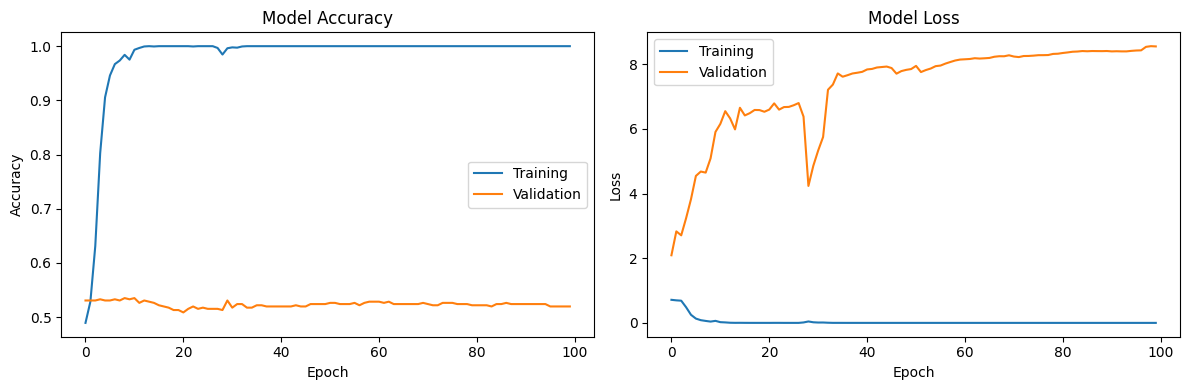

In [ ]:
predicted_labels = model.predict([X_test_padded, X_test_additional])
y_pred = predicted_labels.round()
y_true = y_test


print_classification_report(y_true, y_pred)


plot_training_history(history)


# Hypertunning LSTM and adding regularization

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

In [ ]:
train_df, test_df = train_test_split(features, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['preprocessed'])
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed'])


In [ ]:
max_len = 100
X_train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')



In [ ]:
additional_features = train_df.drop(['date', 'preprocessed', 'label'], axis=1).columns.tolist()
X_train_additional = train_df.drop(['date', 'preprocessed', 'label'], axis=1).values
X_test_additional = test_df.drop(['date', 'preprocessed', 'label'], axis=1).values


In [ ]:
scaler = StandardScaler()
X_train_additional = scaler.fit_transform(X_train_additional)
X_test_additional = scaler.transform(X_test_additional)


In [ ]:
y_train = train_df['label'].values
y_test = test_df['label'].values


In [ ]:
embedding_dim = 64
lstm_units = 128
dropout_rate = 0.5
l2_lambda = 0.0001

In [ ]:
text_input = Input(shape=(max_len,))
additional_input = Input(shape=(len(additional_features),))


In [ ]:
embedded = Embedding(max_words, embedding_dim, input_length=max_len)(text_input)
lstm_out = LSTM(lstm_units, dropout=dropout_rate)(embedded)

merged = Concatenate()([lstm_out, additional_input])
dense = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(merged)
dropout = Dropout(dropout_rate)(dense)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda))(dropout)

model = Model(inputs=[text_input, additional_input], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
num_epochs = 50
history = model.fit([X_train_padded, X_train_additional], y_train, epochs=num_epochs, validation_data=([X_test_padded, X_test_additional], y_test))

Epoch 1/50
57/57 [==============================] - 12s 170ms/step - loss: 0.7235 - accuracy: 0.4829 - val_loss: 0.7022 - val_accuracy: 0.5330
Epoch 2/50
57/57 [==============================] - 7s 120ms/step - loss: 0.6998 - accuracy: 0.5204 - val_loss: 0.6983 - val_accuracy: 0.5308
Epoch 3/50
57/57 [==============================] - 5s 85ms/step - loss: 0.6953 - accuracy: 0.5088 - val_loss: 0.7017 - val_accuracy: 0.5308
Epoch 4/50
57/57 [==============================] - 4s 68ms/step - loss: 0.6933 - accuracy: 0.5210 - val_loss: 0.7013 - val_accuracy: 0.5286
Epoch 5/50
57/57 [==============================] - 4s 60ms/step - loss: 0.6928 - accuracy: 0.5425 - val_loss: 0.7033 - val_accuracy: 0.5330
Epoch 6/50
57/57 [==============================] - 2s 37ms/step - loss: 0.6966 - accuracy: 0.5017 - val_loss: 0.7007 - val_accuracy: 0.5551
Epoch 7/50
57/57 [==============================] - 1s 22ms/step - loss: 0.6933 - accuracy: 0.5061 - val_loss: 0.7029 - val_accuracy: 0.5396
Epoch 8/50

In [ ]:
test_loss, test_accuracy = model.evaluate([X_test_padded, X_test_additional], y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

15/15 [==============================] - 0s 3ms/step - loss: 3.7300 - accuracy: 0.5088
Test accuracy: 0.5088


15/15 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.44      0.45       213
           1       0.53      0.57      0.55       241

    accuracy                           0.51       454
   macro avg       0.50      0.50      0.50       454
weighted avg       0.51      0.51      0.51       454



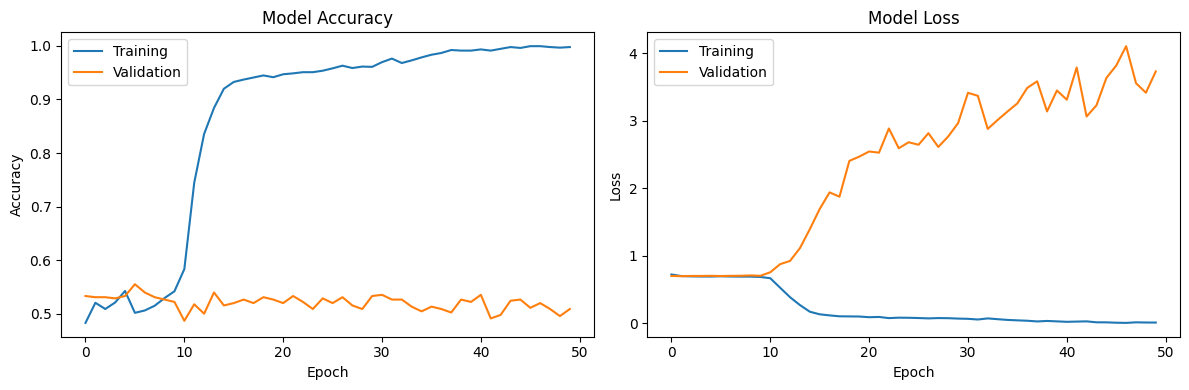

In [ ]:
predicted_labels = model.predict([X_test_padded, X_test_additional])
y_pred = predicted_labels.round()
y_true = y_test


print_classification_report(y_true, y_pred)


plot_training_history(history)


# Another LSTM model which is aimed at reducing overfitting in the model

In [159]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

In [160]:
train_df, test_df = train_test_split(features, test_size=0.2, random_state=42, shuffle=False)


In [161]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['preprocessed'])
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed'])


In [162]:
max_len = 100
X_train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')



In [163]:
additional_features = train_df.drop(['date', 'preprocessed', 'label'], axis=1).columns.tolist()
X_train_additional = train_df.drop(['date', 'preprocessed', 'label'], axis=1).values
X_test_additional = test_df.drop(['date', 'preprocessed', 'label'], axis=1).values


In [164]:
scaler = StandardScaler()
X_train_additional = scaler.fit_transform(X_train_additional)
X_test_additional = scaler.transform(X_test_additional)


In [165]:
y_train = train_df['label'].values
y_test = test_df['label'].values


In [166]:
embedding_dim = 64
lstm_units = 64
dropout_rate = 0.5
l2_lambda = 0.001

In [167]:
text_input = Input(shape=(max_len,))
additional_input = Input(shape=(len(additional_features),))


In [ ]:
embedded = Embedding(max_words, embedding_dim, input_length=max_len)(text_input)
lstm_out = LSTM(lstm_units, dropout=dropout_rate, kernel_regularizer=l2(l2_lambda))(embedded)  
lstm_out = Dropout(dropout_rate)(lstm_out)  
merged = Concatenate()([lstm_out, additional_input])
dense = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(merged)
dropout = Dropout(dropout_rate)(dense)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda))(dropout)

model = Model(inputs=[text_input, additional_input], outputs=output)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
num_epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)  

history = model.fit([X_train_padded, X_train_additional], y_train, epochs=num_epochs, validation_data=([X_test_padded, X_test_additional], y_test), callbacks=[early_stopping, model_checkpoint])  # Added callbacks

Epoch 1/50
57/57 [==============================] - 10s 140ms/step - loss: 0.8168 - accuracy: 0.5199 - val_loss: 0.7595 - val_accuracy: 0.5551
Epoch 2/50
57/57 [==============================] - 4s 73ms/step - loss: 0.7581 - accuracy: 0.5011 - val_loss: 0.7316 - val_accuracy: 0.5132
Epoch 3/50
57/57 [==============================] - 4s 79ms/step - loss: 0.7355 - accuracy: 0.5083 - val_loss: 0.7233 - val_accuracy: 0.5507
Epoch 4/50
57/57 [==============================] - 4s 68ms/step - loss: 0.7164 - accuracy: 0.5270 - val_loss: 0.7222 - val_accuracy: 0.5551
Epoch 5/50
57/57 [==============================] - 2s 36ms/step - loss: 0.7157 - accuracy: 0.5397 - val_loss: 0.7180 - val_accuracy: 0.5639
Epoch 6/50
57/57 [==============================] - 2s 43ms/step - loss: 0.7092 - accuracy: 0.5568 - val_loss: 0.7217 - val_accuracy: 0.5573
Epoch 7/50
57/57 [==============================] - 1s 26ms/step - loss: 0.6692 - accuracy: 0.6407 - val_loss: 0.7331 - val_accuracy: 0.5661
Epoch 8/50


In [ ]:
test_loss, test_accuracy = model.evaluate([X_test_padded, X_test_additional], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 0s 4ms/step - loss: 0.7180 - accuracy: 0.5639
Test Loss: 0.7179867029190063
Test Accuracy: 0.5638766288757324


15/15 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.25      0.35       213
           1       0.56      0.84      0.67       241

    accuracy                           0.56       454
   macro avg       0.57      0.55      0.51       454
weighted avg       0.57      0.56      0.52       454



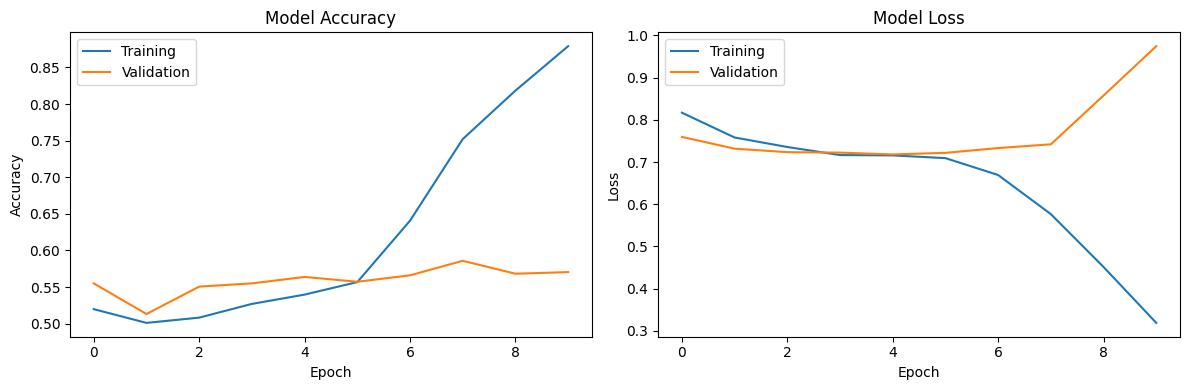

In [ ]:
predicted_labels = model.predict([X_test_padded, X_test_additional])
y_pred = predicted_labels.round()
y_true = y_test


print_classification_report(y_true, y_pred)


plot_training_history(history)


In [168]:
embedded = Embedding(max_words, embedding_dim, input_length=max_len)(text_input)
lstm_out = LSTM(lstm_units, dropout=dropout_rate, kernel_regularizer=l2(l2_lambda))(embedded) 
lstm_out = Dropout(dropout_rate)(lstm_out)  

merged = Concatenate()([lstm_out, additional_input])
dense = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(merged)
dropout = Dropout(dropout_rate)(dense)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda))(dropout)

model = Model(inputs=[text_input, additional_input], outputs=output)


In [169]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [170]:
num_epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)  

history = model.fit([X_train_padded, X_train_additional], y_train, epochs=num_epochs, validation_data=([X_test_padded, X_test_additional], y_test), callbacks=[early_stopping, model_checkpoint])  # Added callbacks

Epoch 1/50
57/57 [==============================] - 13s 190ms/step - loss: 0.8220 - accuracy: 0.5044 - val_loss: 0.7601 - val_accuracy: 0.4890
Epoch 2/50
57/57 [==============================] - 8s 138ms/step - loss: 0.7569 - accuracy: 0.5210 - val_loss: 0.7300 - val_accuracy: 0.5441
Epoch 3/50
57/57 [==============================] - 5s 84ms/step - loss: 0.7243 - accuracy: 0.5364 - val_loss: 0.7238 - val_accuracy: 0.5242
Epoch 4/50
57/57 [==============================] - 5s 87ms/step - loss: 0.7227 - accuracy: 0.5254 - val_loss: 0.7185 - val_accuracy: 0.5198
Epoch 5/50
57/57 [==============================] - 3s 54ms/step - loss: 0.7026 - accuracy: 0.5530 - val_loss: 0.7194 - val_accuracy: 0.5330
Epoch 6/50
57/57 [==============================] - 1s 22ms/step - loss: 0.6136 - accuracy: 0.7014 - val_loss: 0.7425 - val_accuracy: 0.5727
Epoch 7/50
57/57 [==============================] - 2s 33ms/step - loss: 0.4455 - accuracy: 0.8300 - val_loss: 0.7992 - val_accuracy: 0.5507
Epoch 8/50

In [171]:
test_loss, test_accuracy = model.evaluate([X_test_padded, X_test_additional], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 0s 4ms/step - loss: 0.7185 - accuracy: 0.5198
Test Loss: 0.7184832096099854
Test Accuracy: 0.5198237895965576


In [172]:
predicted_labels = model.predict([X_test_padded, X_test_additional])


15/15 [==============================] - 0s 3ms/step


In [173]:
predicted_df = pd.DataFrame({'date': test_df['date'], 'label': predicted_labels.ravel().round()})


In [174]:
predicted_df.head()

,date,label
1812,2020-03-16,0.0
1813,2020-03-17,1.0
1814,2020-03-18,1.0
1815,2020-03-19,1.0
1816,2020-03-20,1.0


In [175]:
train_labels_df = train_df[['date', 'label']].copy()


In [176]:
train_labels_df.head()

,date,label
0,2013-01-02,0
1,2013-01-03,0
2,2013-01-04,0
3,2013-01-07,1
4,2013-01-08,0


In [177]:
print(train_labels_df.iloc[-1])

date     2020-03-13
label             1
Name: 1811, dtype: object


In [178]:
merged_df = pd.concat([train_labels_df, predicted_df])
print(len(merged_df))

2266


In [179]:
merged_df.head()

,date,label
0,2013-01-02,0.0
1,2013-01-03,0.0
2,2013-01-04,0.0
3,2013-01-07,1.0
4,2013-01-08,0.0


In [180]:
output = '/content/drive/MyDrive/Dissertation/predicted_labels1.csv'
merged_df.to_csv(output)

# Another LSTM

In [ ]:
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras_tuner-1.3.5-py3-none-any.whl (176 kB)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd


# Mount Google Drive
drive.mount('/content/drive')

<ipython-input-3-c99a9546df58>:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Mounted at /content/drive


In [ ]:
filename = '/content/drive/MyDrive/Dissertation/merged_df_mean.csv'
features = pd.read_csv(filename)

In [ ]:
train_df, test_df = train_test_split(features, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['preprocessed'])
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed'])


In [ ]:
max_len = 100
X_train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')



In [ ]:
additional_features = train_df.drop(['date', 'preprocessed', 'label'], axis=1).columns.tolist()
X_train_additional = train_df.drop(['date', 'preprocessed', 'label'], axis=1).values
X_test_additional = test_df.drop(['date', 'preprocessed', 'label'], axis=1).values


In [ ]:
scaler = StandardScaler()
X_train_additional = scaler.fit_transform(X_train_additional)
X_test_additional = scaler.transform(X_test_additional)


In [ ]:
y_train = train_df['label'].values
y_test = test_df['label'].values


In [ ]:
def build_model(hp):
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=128, step=16)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    l2_lambda = hp.Float('l2_lambda', min_value=0.0001, max_value=0.01, step=0.0005)

    text_input = Input(shape=(max_len,))
    additional_input = Input(shape=(len(additional_features),))

    embedded = Embedding(max_words, embedding_dim, input_length=max_len)(text_input)
    lstm_out = LSTM(lstm_units, dropout=dropout_rate, kernel_regularizer=l2(l2_lambda))(embedded)
    lstm_out = Dropout(dropout_rate)(lstm_out)

    merged = Concatenate()([lstm_out, additional_input])
    dense = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(merged)
    dropout = Dropout(dropout_rate)(dense)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda))(dropout)

    model = Model(inputs=[text_input, additional_input], outputs=output)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
num_epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='lstm_hyperparams',
    seed=42
  )

In [ ]:
tuner.search_space_summary()

tuner.search([X_train_padded, X_train_additional], y_train, epochs=num_epochs, validation_data=([X_test_padded, X_test_additional], y_test), callbacks=[early_stopping])

Trial 10 Complete [00h 00m 39s]
val_loss: 0.802081286907196

Best val_loss So Far: 0.6922707557678223
Total elapsed time: 00h 07m 21s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
test_loss, test_accuracy = best_model.evaluate([X_test_padded, X_test_additional], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 1s 4ms/step - loss: 0.6923 - accuracy: 0.5396
Test Loss: 0.6922707557678223
Test Accuracy: 0.5396475791931152


In [ ]:
print("Best Hyperparameters:")
print("Embedding Dimension:", best_hyperparameters.get('embedding_dim'))
print("LSTM Units:", best_hyperparameters.get('lstm_units'))
print("Dropout Rate:", best_hyperparameters.get('dropout_rate'))
print("L2 Lambda:", best_hyperparameters.get('l2_lambda'))

Best Hyperparameters:
Embedding Dimension: 80
LSTM Units: 48
Dropout Rate: 0.5
L2 Lambda: 0.0061


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report




predicted_labels = best_model.predict([X_test_padded, X_test_additional])

y_pred = predicted_labels.round()
y_true = y_test

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, predicted_labels)


y_pred = predicted_labels.round()
y_true = y_test


report = classification_report(y_true, y_pred, digits=2)

print("Classification Report:")
print(report)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)

15/15 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.11      0.19       213
           1       0.54      0.92      0.68       241

    accuracy                           0.54       454
   macro avg       0.54      0.51      0.43       454
weighted avg       0.54      0.54      0.45       454

Accuracy: 0.539647577092511
Precision: 0.5390243902439025
Recall: 0.91701244813278
F1 score: 0.6789554531490016
ROC AUC score: 0.5523737167124461


In [ ]:
predicted_df = pd.DataFrame({'date': test_df['date'], 'label': predicted_labels.ravel().round()})


In [ ]:
predicted_df.head()

,date,label
1812,2020-03-16,1.0
1813,2020-03-17,1.0
1814,2020-03-18,1.0
1815,2020-03-19,1.0
1816,2020-03-20,1.0


In [ ]:
train_labels_df = train_df[['date', 'label']].copy()


In [ ]:
train_labels_df.head()

,date,label
0,2013-01-02,0
1,2013-01-03,0
2,2013-01-04,0
3,2013-01-07,1
4,2013-01-08,0


In [ ]:
print(train_labels_df.iloc[-1])

date     2020-03-13
label             1
Name: 1811, dtype: object


In [ ]:
merged_df = pd.concat([train_labels_df, predicted_df])
print(len(merged_df))

2266


In [ ]:
merged_df.head()

,date,label
0,2013-01-02,0.0
1,2013-01-03,0.0
2,2013-01-04,0.0
3,2013-01-07,1.0
4,2013-01-08,0.0


In [ ]:
output = '/content/drive/MyDrive/Dissertation/predicted_labels.csv'
merged_df.to_csv(output)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_training_curves(history):
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    epochs = range(1, len(val_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, X_test_padded, X_test_additional, y_test):
 
    test_loss, test_accuracy = model.evaluate([X_test_padded, X_test_additional], y_test)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)


    y_pred = model.predict([X_test_padded, X_test_additional]).round().astype(int)


    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

 
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

15/15 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5308
Test Loss: 0.6927780508995056
Test Accuracy: 0.5308369994163513
15/15 [==============================] - 1s 3ms/step


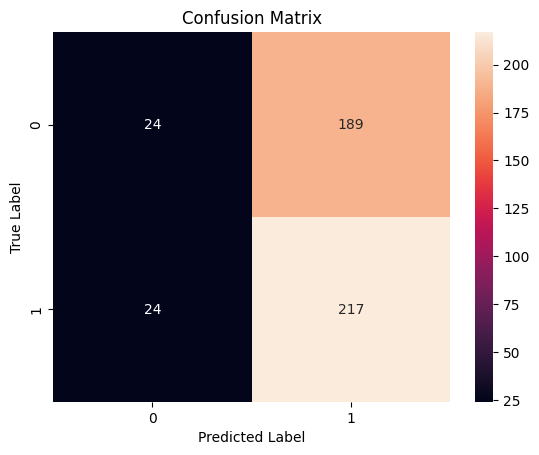

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.11      0.18       213
           1       0.53      0.90      0.67       241

    accuracy                           0.53       454
   macro avg       0.52      0.51      0.43       454
weighted avg       0.52      0.53      0.44       454



In [ ]:
evaluate_model(best_model, X_test_padded, X_test_additional, y_test)




# Creating stock data with indicators - change the code

In [9]:
import pandas
import numpy
import yfinance as yf

In [10]:
start_date = "2013-01-01"
end_date = "2021-12-31"
ticker = "AAPL"
stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [11]:
def calculate_obv(df):
    on_balance_volume = [0]
    for i in range(1, len(df)):
        if df['Close'][i] > df['Close'][i-1]:
            on_balance_volume.append(on_balance_volume[-1] + df['Volume'][i])
        elif df['Close'][i] < df['Close'][i-1]:
            on_balance_volume.append(on_balance_volume[-1] - df['Volume'][i])
        else:
            on_balance_volume.append(on_balance_volume[-1])
    return pd.Series(on_balance_volume, index=df.index, name='OBV')

In [12]:
def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.rename('RSI')

In [13]:
def calculate_bollinger_bands(data, period=20, std_dev=2):
    sma = data['Close'].rolling(window=period).mean()
    std_deviation = data['Close'].rolling(window=period).std()
    upper_band = sma + (std_deviation * std_dev)
    lower_band = sma - (std_deviation * std_dev)
    return sma.rename('SMA'), upper_band.rename('UpperBand'), lower_band.rename('LowerBand')


In [14]:
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    exp1 = data['Close'].ewm(span=short_period, adjust=False).mean()
    exp2 = data['Close'].ewm(span=long_period, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd.rename('MACD'), signal_line.rename('SignalLine')

# Creating the LSTM model - first try - without twitter data in it

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
features = stock_data[['Close', 'OBV', 'RSI', 'UpperBand', 'LowerBand', 'MACD', 'SignalLine']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

In [ ]:
lookback = 60
train_size = int(len(scaled_data) * 0.8)

def create_dataset(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

In [ ]:
X, Y = create_dataset(scaled_data, lookback)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=64, epochs=100, verbose=1)



In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

13/13 [==============================] - 0s 20ms/step


In [ ]:
close_scaler = MinMaxScaler()
close_scaler.fit(stock_data[['Close']])
train_predictions = close_scaler.inverse_transform(train_predictions)
test_predictions = close_scaler.inverse_transform(test_predictions)


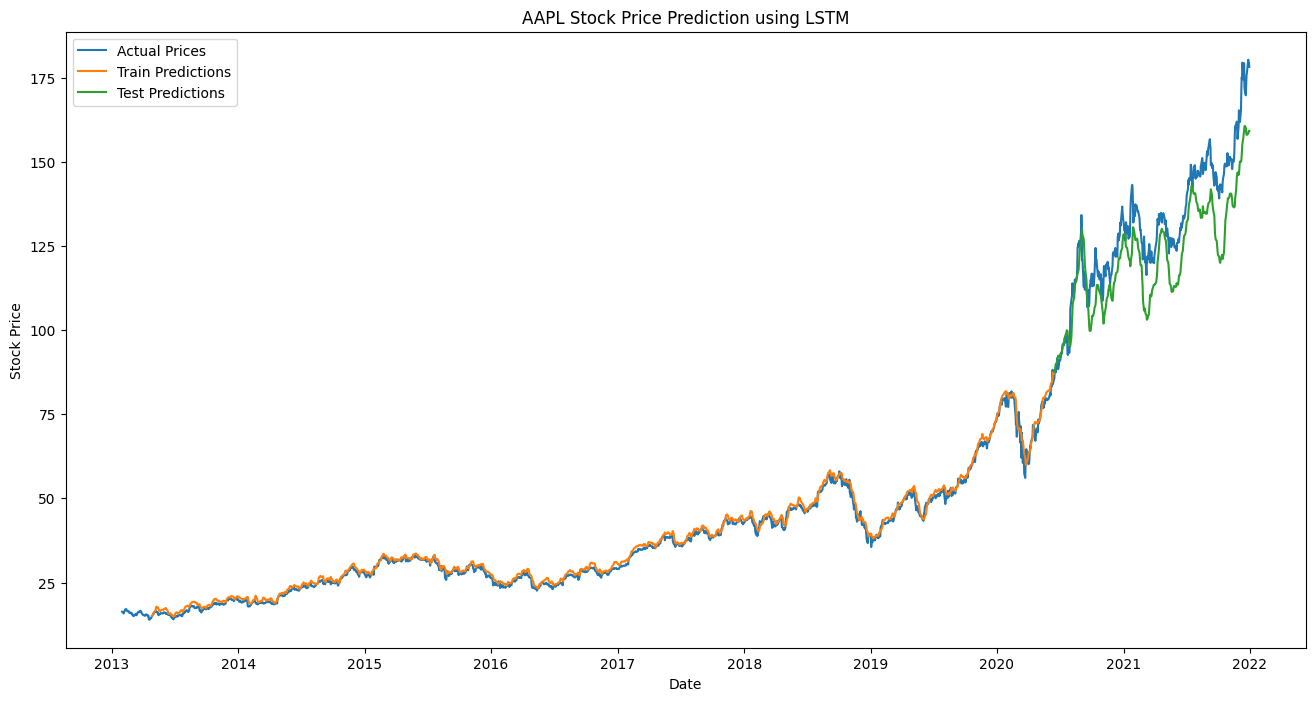

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index, stock_data['Close'], label='Actual Prices')
plt.plot(stock_data.index[lookback:lookback + train_size], train_predictions, label='Train Predictions')
plt.plot(stock_data.index[lookback + train_size:], test_predictions, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.legend()
plt.show()

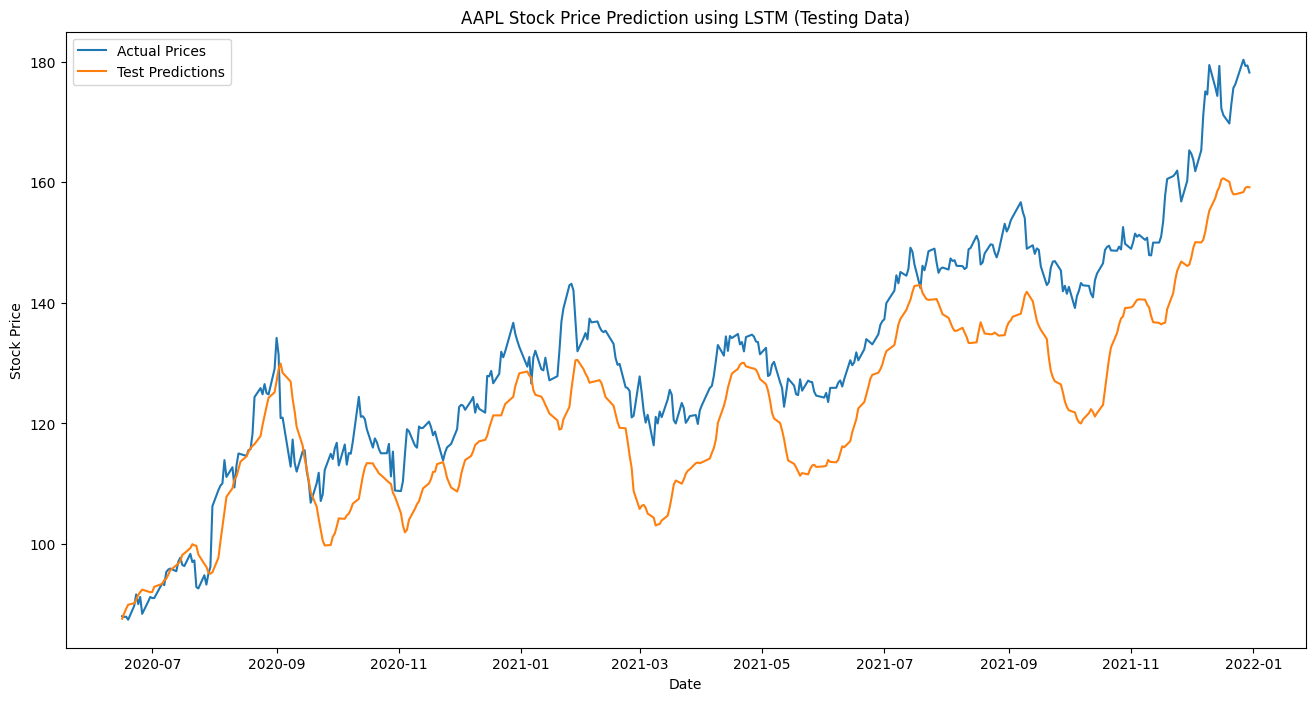

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index[lookback + train_size:], stock_data['Close'][lookback + train_size:], label='Actual Prices')
plt.plot(stock_data.index[lookback + train_size:], test_predictions, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM (Testing Data)')
plt.legend()
plt.show()

In [ ]:
def same_direction_check(actual_prices, predicted_prices):
  count_same_direction = 0
  count_total = len(actual_prices) - 1

  for i in range(1, len(actual_prices)):
    actual_change = actual_prices[i] - actual_prices[i-1]
    predicted_change = predicted_prices[i] - predicted_prices[i-1]

    if(actual_change > 0 and predicted_change > 0) or (actual_change < 0 and predicted_change < 0):
      count_same_direction += 1
    

  percentage_same_direction = (count_same_direction / count_total) * 100
  return count_same_direction, count_total, percentage_same_direction


In [ ]:
actual_prices_test = stock_data['Close'][lookback + train_size:]
count_same_direction, count_total, percentage_same_direction = same_direction_check(actual_prices_test, test_predictions)
print(f"Out of {count_total} price changes in the testing data, {count_same_direction} were in the same direction "
      f"as the predictions ({percentage_same_direction:.2f}%).")


Out of 389 price changes in the testing data, 184 were in the same direction as the predictions (47.30%).


In [ ]:
def same_trend_dates(actual_prices, predicted_prices, dates):
    same_trend_dates = []

    for i in range(1, len(actual_prices)):
        actual_diff = actual_prices[i] - actual_prices[i - 1]
        predicted_diff = predicted_prices[i] - predicted_prices[i - 1]

        if (actual_diff > 0 and predicted_diff > 0) or (actual_diff < 0 and predicted_diff < 0):
            same_trend_dates.append(dates[i])

    return same_trend_dates


actual_prices_test = stock_data['Close'][lookback + train_size:]
dates_test = stock_data.index[lookback + train_size:]
dates_with_same_trend = same_trend_dates(actual_prices_test, test_predictions, dates_test)

print(f"The following dates have the same trend (both actual and predicted prices going up or down together):")
for date in dates_with_same_trend:
    print(date)

The following dates have the same trend (both actual and predicted prices going up or down together):
2020-06-18 00:00:00
2020-06-22 00:00:00
2020-06-23 00:00:00
2020-06-25 00:00:00
2020-07-06 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-20 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-28 00:00:00
2020-07-31 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-10 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00
2020-08-21 00:00:00
2020-08-24 00:00:00
2020-08-26 00:00:00
2020-08-31 00:00:00
2020-09-01 00:00:00
2020-09-08 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-16 00:00:00
2020-09-17 00:00:00
2020-09-18 00:00:00
2020-09-23 00:00:00
2020-09-28 00:00:00
2020-09-30 00:00:00
2020-10-01 00:00:00
2020-10-07 00:00:00
2020-10-09 00:00:00
2020-10-12 00:00:00
2020-10-14 00:00:00
2020-10-19 00:00:0

In [ ]:
first_date_in_testing_set = dates_test[0]
print(f"The first date in the testing set is: {first_date_in_testing_set}")

first_date_in_testing_set = dates_test[1]
print(f"The first date in the testing set is: {first_date_in_testing_set}")

first_date_in_testing_set = dates_test[2]

print(f"The first date in the testing set is: {first_date_in_testing_set}")


The first date in the testing set is: 2020-06-16 00:00:00
The first date in the testing set is: 2020-06-17 00:00:00
The first date in the testing set is: 2020-06-18 00:00:00


# Creating LSTM model to check price movement after given amount of time 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [4]:
stock_df = stock_data

In [5]:
def make_price_direction_label(stock_df, time_period):
  stock_df['PriceDirection'] = (stock_data['Close'].shift(-time_period) >stock_df['Close']).astype(int)
  return stock_df

In [6]:
stock_df = make_price_direction_label(stock_df, 1)

In [7]:
stock_df = stock_df[:7]

In [ ]:
features = stock_data[['Close', 'OBV', 'RSI', 'UpperBand', 'LowerBand', 'MACD', 'SignalLine']]
target = stock_data['PriceDirection']

In [ ]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1)


Epoch 1/100
29/29 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.5698
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5042
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5042
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5042
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5042
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5042
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5042
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5042
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5042
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5042
Epoch 11/100
29/29 [===================

In [ ]:
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")

15/15 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.48


# Creating model which is without tweets but trying to eliminate data leakage 

In [37]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [16]:
import pandas
import numpy
import yfinance as yf

In [17]:
start_date = "2013-01-01"
end_date = "2021-12-31"
ticker = "AAPL"
stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [25]:
def make_price_direction_label(stock_df, time_period):
    target = np.zeros(len(stock_df))
    target[:-time_period] = np.where(stock_df['Close'].values[time_period:] > stock_df['Close'].values[:-time_period], 1, 0)
    target[-time_period:] = np.nan
    stock_df['Target'] = target
    return stock_df

In [ ]:
def create_model_given_time_period(stock_data, time_period):
  train_size = int(len(stock_data) * 0.8)
  train_data = stock_data.iloc[:train_size].copy()
  test_data = stock_data.iloc[train_size:].copy()

  train_data['OBV_diff'] = calculate_obv(train_data).diff()
  train_data['RSI_diff'] = calculate_rsi(train_data).diff()
  train_data['SMA_diff'], train_data['UpperBand_diff'], train_data['LowerBand_diff'] = calculate_bollinger_bands(train_data)
  train_data['MACD_diff'], train_data['SignalLine_diff'] = calculate_macd(train_data)
  train_data = make_price_direction_label(train_data, time_period)


  test_data['OBV_diff'] = calculate_obv(test_data).diff()
  test_data['RSI_diff'] = calculate_rsi(test_data).diff()
  test_data['SMA_diff'], test_data['UpperBand_diff'], test_data['LowerBand_diff'] = calculate_bollinger_bands(test_data)
  test_data['MACD_diff'], test_data['SignalLine_diff'] = calculate_macd(test_data)
  test_data = make_price_direction_label(test_data, time_period)


  train_data.dropna(inplace=True)
  test_data.dropna(inplace=True)


  X_train = train_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff']]
  y_train = train_data['Target']
  X_test = test_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff']]
  y_test = test_data['Target']


  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)


  tscv = TimeSeriesSplit(n_splits=5)
  accuracy_scores = []

  for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled), start=1):
      X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
      y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
      model = Sequential()
      model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)))
      model.add(Dropout(0.2))
      model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(0.2))
      model.add(Dense(1, activation='sigmoid'))

      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

      history = model.fit(X_train_fold, y_train_fold, batch_size=64, epochs=100, verbose=0, validation_data=(X_val_fold, y_val_fold))

      def plot_learning_curves(history, fold):
          plt.figure()
          plt.plot(history.history['loss'], label='Training Loss')
          plt.plot(history.history['val_loss'], label='Validation Loss')
          plt.xlabel('Epochs')
          plt.ylabel('Loss')
          plt.legend()

          final_train_loss = history.history['loss'][-1]
          final_val_loss = history.history['val_loss'][-1]

          plt.title(f'Fold {fold}: Train Loss={final_train_loss:.3f}, Val Loss={final_val_loss:.3f}')
          plt.show()

      

      y_val_pred = (model.predict(X_val_fold) > 0.5).astype(int)
      accuracy = accuracy_score(y_val_fold, y_val_pred)
      accuracy_scores.append(accuracy)

  mean_accuracy = np.mean(accuracy_scores)
  print(f"Time period: {time_period}, Mean accuracy over 5 folds: {mean_accuracy:.2f}")



  model.fit(X_train_scaled, y_train, batch_size=64, epochs=100, verbose=0)


  y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
  accuracy = accuracy_score(y_test, y_test_pred)

  print(f"Time period: {time_period}, Accuracy on testing set: {accuracy:.2f}")


In [26]:
def assign_indicator_differences(data, time_period):
  data['OBV_diff'] = calculate_obv(data).diff()
  data['RSI_diff'] = calculate_rsi(data).diff()
  data['SMA_diff'], data['UpperBand_diff'], data['LowerBand_diff'] = calculate_bollinger_bands(data)
  data['MACD_diff'], data['SignalLine_diff'] = calculate_macd(data)
  data = make_price_direction_label(data, time_period)
  return data

In [27]:
def create_split(train_data, test_data):
  X_train = train_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff']]
  y_train = train_data['Target']
  X_test = test_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff']]
  y_test = test_data['Target']

  return X_train, y_train, X_test, y_test

In [28]:
def plot_curve(model, fold):
  plt.figure()
  plt.plot(model.history['loss'], label='Training Loss')
  plt.plot(model.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  final_train_loss = model.history['loss'][-1]
  final_val_loss = model.history['val_loss'][-1]

  plt.title(f'Fold {fold}: Train Loss={final_train_loss:.3f}, Val Loss={final_val_loss:.3f}')
  plt.show()

     

In [29]:
def create_model_1(X_train):
  model = Sequential()
  model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [38]:
def create_model_given_time_period(stock_data, time_period):
  train_size = int(len(stock_data) * 0.8)
  train_data = stock_data.iloc[:train_size].copy()
  test_data = stock_data.iloc[train_size:].copy()



  train_data = assign_indicator_differences(train_data, time_period)
  test_data = assign_indicator_differences(test_data, time_period)


  train_data.dropna(inplace=True)
  test_data.dropna(inplace=True)


  X_train, y_train, X_test, y_test = create_split(train_data, test_data)


  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)


  tscv = TimeSeriesSplit(n_splits=5)
  accuracy_scores = []

  for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled), start=1):
      X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
      y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
      
      model = create_model_1(X_train)

      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

      history = model.fit(X_train_fold, y_train_fold, batch_size=64, epochs=100, verbose=0, validation_data=(X_val_fold, y_val_fold))

      


      y_val_pred = (model.predict(X_val_fold) > 0.5).astype(int)
      accuracy = accuracy_score(y_val_fold, y_val_pred)
      accuracy_scores.append(accuracy)

  mean_accuracy = np.mean(accuracy_scores)
  print(f"Time period: {time_period}, Mean accuracy over 5 folds: {mean_accuracy:.2f}")



  model.fit(X_train_scaled, y_train, batch_size=64, epochs=100, verbose=0)

  y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
  accuracy = accuracy_score(y_test, y_test_pred)

  print(f"Time period: {time_period}, Accuracy on testing set: {accuracy:.2f}")


In [46]:
for time_period in range(1, 10):
  create_model_given_time_period(stock_data, time_period)

10/10 [==============================] - 0s 1ms/step
Time period: 1, Mean accuracy over 5 folds: 0.50
14/14 [==============================] - 0s 1ms/step
Time period: 1, Accuracy on testing set: 0.55
10/10 [==============================] - 0s 1ms/step
Time period: 2, Mean accuracy over 5 folds: 0.55
14/14 [==============================] - 0s 1ms/step
Time period: 2, Accuracy on testing set: 0.56
10/10 [==============================] - 0s 1ms/step
Time period: 3, Mean accuracy over 5 folds: 0.56
14/14 [==============================] - 0s 1ms/step
Time period: 3, Accuracy on testing set: 0.52
10/10 [==============================] - 0s 1ms/step
Time period: 4, Mean accuracy over 5 folds: 0.56
14/14 [==============================] - 0s 1ms/step
Time period: 4, Accuracy on testing set: 0.51
10/10 [==============================] - 0s 1ms/step
Time period: 5, Mean accuracy over 5 folds: 0.55
14/14 [==============================] - 0s 1ms/step
Time period: 5, Accuracy on testing set: 

# Creating model with predicted tweets labels

In [2]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd


# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [240]:
filename = '/content/drive/MyDrive/Dissertation/predicted_labels2.csv'
tweets_labels = pd.read_csv(filename)

In [241]:
import pandas
import numpy
import yfinance as yf

In [242]:
start_date = "2013-01-01"
end_date = "2021-12-31"
ticker = "AAPL"
stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [243]:
tweets_labels.head()

,Unnamed: 0,date,label
0,0,2013-01-02,0.0
1,1,2013-01-03,0.0
2,2,2013-01-04,0.0
3,3,2013-01-07,1.0
4,4,2013-01-08,0.0


In [244]:
tweets_labels = tweets_labels[['date', 'label']]
tweets_labels.head()

,date,label
0,2013-01-02,0.0
1,2013-01-03,0.0
2,2013-01-04,0.0
3,2013-01-07,1.0
4,2013-01-08,0.0


In [245]:
print(len(tweets_labels))
print(len(stock_data))

2266
2266


In [246]:
stock_data = stock_data.reset_index()


In [247]:

stock_data = stock_data.rename(columns={'Date': 'date'})

stock_data.head()


,date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.837124,560518000
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.624596,352965200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.161530,594333600
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.066450,484156400
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.109692,458707200


In [248]:
stock_data['tweet_label'] = tweets_labels['label']

In [249]:
stock_data.head()

,date,Open,High,Low,Close,Adj Close,Volume,tweet_label
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.837124,560518000,0.0
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.624596,352965200,0.0
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.161530,594333600,0.0
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.066450,484156400,1.0
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.109692,458707200,0.0


In [16]:
def make_price_direction_label(stock_df, time_period):
    target = np.zeros(len(stock_df))
    target[:-time_period] = np.where(stock_df['Close'].values[time_period:] > stock_df['Close'].values[:-time_period], 1, 0)
    target[-time_period:] = np.nan
    stock_df['Target'] = target
    return stock_df

In [6]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler


In [5]:
!pip install keras-tuner
from kerastuner.tuners import RandomSearch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.6 MB/s eta 0:00:00


<ipython-input-5-5fd222b42156>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , TimeDistributed
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [8]:
def calculate_obv(df):
    on_balance_volume = [0]
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
            on_balance_volume.append(on_balance_volume[-1] + df['Volume'].iloc[i])
        elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
            on_balance_volume.append(on_balance_volume[-1] - df['Volume'].iloc[i])
        else:
            on_balance_volume.append(on_balance_volume[-1])
    return pd.Series(on_balance_volume, index=df.index, name='OBV')

In [ ]:
  train_size = int(len(stock_data) * 0.8)
  train_data = stock_data.iloc[:train_size].copy()
  test_data = stock_data.iloc[train_size:].copy()
  time_period = 3

  train_data['OBV_diff'] = calculate_obv(train_data).diff()
  train_data['RSI_diff'] = calculate_rsi(train_data).diff()
  train_data['SMA_diff'], train_data['UpperBand_diff'], train_data['LowerBand_diff'] = calculate_bollinger_bands(train_data)
  train_data['MACD_diff'], train_data['SignalLine_diff'] = calculate_macd(train_data)
  train_data = make_price_direction_label(train_data, time_period)


  test_data['OBV_diff'] = calculate_obv(test_data).diff()
  test_data['RSI_diff'] = calculate_rsi(test_data).diff()
  test_data['SMA_diff'], test_data['UpperBand_diff'], test_data['LowerBand_diff'] = calculate_bollinger_bands(test_data)
  test_data['MACD_diff'], test_data['SignalLine_diff'] = calculate_macd(test_data)
  test_data = make_price_direction_label(test_data, time_period)


  train_data.dropna(inplace=True)
  test_data.dropna(inplace=True)


  X_train = train_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff', 'tweet_label']]
  y_train = train_data['Target']
  X_test = test_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff', 'tweet_label']]
  y_test = test_data['Target']

In [1]:
def build_feat(time_period, source):
  filename = '/content/drive/MyDrive/Dissertation/predicted_labels2.csv'
  tweets_labels = pd.read_csv(filename)
  import pandas
  import numpy
  import yfinance as yf

  start_date = "2013-01-01"
  end_date = "2021-12-31"
  ticker = "AAPL"
  stock_data = yf.download(ticker, start=start_date, end=end_date)
  tweets_labels = tweets_labels[['date', 'label']]
  stock_data = stock_data.reset_index()
  stock_data = stock_data.rename(columns={'Date': 'date'})
  stock_data['tweet_label'] = tweets_labels['label']
  
  train_size = int(len(stock_data) * 0.8)
  train_data = stock_data.iloc[:train_size].copy()
  test_data = stock_data.iloc[train_size:].copy()
  

  train_data['OBV_diff'] = calculate_obv(train_data).diff()
  train_data['RSI_diff'] = calculate_rsi(train_data).diff()
  train_data['SMA_diff'], train_data['UpperBand_diff'], train_data['LowerBand_diff'] = calculate_bollinger_bands(train_data)
  train_data['MACD_diff'], train_data['SignalLine_diff'] = calculate_macd(train_data)
  train_data = make_price_direction_label(train_data, time_period)


  test_data['OBV_diff'] = calculate_obv(test_data).diff()
  test_data['RSI_diff'] = calculate_rsi(test_data).diff()
  test_data['SMA_diff'], test_data['UpperBand_diff'], test_data['LowerBand_diff'] = calculate_bollinger_bands(test_data)
  test_data['MACD_diff'], test_data['SignalLine_diff'] = calculate_macd(test_data)
  test_data = make_price_direction_label(test_data, time_period)


  train_data.dropna(inplace=True)
  test_data.dropna(inplace=True)


  X_train = train_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff', 'tweet_label']]
  y_train = train_data['Target']
  X_test = test_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff', 'tweet_label']]
  y_test = test_data['Target']

  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)


  time_steps = 1
  X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], time_steps, X_train_scaled.shape[1]))
  X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], time_steps, X_test_scaled.shape[1]))

  return X_train_reshaped, X_test_reshaped, y_test, y_train

In [256]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

time_steps = 1
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], time_steps, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], time_steps, X_test_scaled.shape[1]))


In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   kernel_regularizer=l2(hp.Float('lstm_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                   input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG'))))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner',
    project_name='stock_prediction'
)

In [ ]:
tuner.search_space_summary()

tuner.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             verbose=1)

tuner.results_summary()

Trial 20 Complete [00h 00m 33s]
val_accuracy: 0.6033519506454468

Best val_accuracy So Far: 0.6117318272590637
Total elapsed time: 00h 10m 54s
Results summary
Results in lstm_tuner/stock_prediction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
units: 64
lstm_l2_reg: 0.0002864353203357012
dropout_rate: 0.2
dense_units: 32
dense_l2_reg: 3.729693459063402e-05
learning_rate: 0.0001182108850023477
Score: 0.6117318272590637

Trial 06 summary
Hyperparameters:
units: 64
lstm_l2_reg: 2.327638253505493e-05
dropout_rate: 0.4
dense_units: 32
dense_l2_reg: 2.5845157399523015e-05
learning_rate: 0.000296314315141428
Score: 0.6061452627182007

Trial 00 summary
Hyperparameters:
units: 96
lstm_l2_reg: 0.0005498981513304376
dropout_rate: 0.5
dense_units: 32
dense_l2_reg: 3.155802451216674e-05
learning_rate: 0.00035276138234744287
Score: 0.6033519506454468

Trial 02 summary
Hyperparameters:
units: 64
lstm_l2_reg: 0.0008401740215485797
dropout_rat

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]


y_pred = best_model.predict(X_test_reshaped)


y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])


from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

14/14 [==============================] - 1s 3ms/step - loss: 0.6985 - accuracy: 0.5069
Test loss: 0.6984925866127014
Test accuracy: 0.5069444179534912
              precision    recall  f1-score   support

         0.0       0.43      0.69      0.53       176
         1.0       0.64      0.38      0.48       256

    accuracy                           0.51       432
   macro avg       0.54      0.54      0.51       432
weighted avg       0.56      0.51      0.50       432



In [257]:
def build_model2(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   kernel_regularizer=l2(hp.Float('lstm_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                   input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG'))))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [43]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [260]:
tuner2 = RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner2_1',
    project_name='stock_prediction'
)

tuner2.search_space_summary()


tuner2.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

tuner2.results_summary()

best_model = tuner2.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 00m 15s]
val_accuracy: 0.6047486066818237

Best val_accuracy So Far: 0.6047486066818237
Total elapsed time: 00h 06m 12s
Results summary
Results in lstm_tuner2_1/stock_prediction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 19 summary
Hyperparameters:
units: 32
lstm_l2_reg: 3.509461163570976e-05
dropout_rate: 0.4
dense_units: 16
dense_l2_reg: 0.00012988621192420286
learning_rate: 0.004591848176101869
Score: 0.6047486066818237

Trial 00 summary
Hyperparameters:
units: 128
lstm_l2_reg: 0.0004271752453045181
dropout_rate: 0.30000000000000004
dense_units: 48
dense_l2_reg: 0.0003887225238861177
learning_rate: 0.00665358054624574
Score: 0.6033519506454468

Trial 01 summary
Hyperparameters:
units: 64
lstm_l2_reg: 0.00018344086099099588
dropout_rate: 0.2
dense_units: 48
dense_l2_reg: 0.0008503259982314724
learning_rate: 0.0006411977445623413
Score: 0.6033519506454468

Trial 02 summary
Hyperparameters:
units: 32
lstm_l2_reg: 0.0005138869705

In [261]:



y_pred = best_model.predict(X_test_reshaped)


y_pred_binary = (y_pred > 0.5).astype(int)


scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

14/14 [==============================] - 1s 3ms/step - loss: 0.6952 - accuracy: 0.4792
Test loss: 0.6951977610588074
Test accuracy: 0.4791666567325592
              precision    recall  f1-score   support

         0.0       0.42      0.72      0.53       176
         1.0       0.62      0.32      0.42       256

    accuracy                           0.48       432
   macro avg       0.52      0.52      0.47       432
weighted avg       0.54      0.48      0.46       432



In [267]:
X_train_reshaped, X_test_reshaped, y_test, y_train = build_feat(2, stock_data)

[*********************100%***********************]  1 of 1 completed


In [269]:
tuner2 = RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner2_33',
    project_name='stock_prediction'
)

tuner2.search_space_summary()


tuner2.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

tuner2.results_summary()

best_model = tuner2.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 00m 17s]
val_accuracy: 0.5905292630195618

Best val_accuracy So Far: 0.5905292630195618
Total elapsed time: 00h 06m 30s
Results summary
Results in lstm_tuner2_33/stock_prediction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
units: 64
lstm_l2_reg: 1.5972216235120286e-05
dropout_rate: 0.4
dense_units: 32
dense_l2_reg: 0.0006990703300813505
learning_rate: 0.001778812677537875
Score: 0.5905292630195618

Trial 01 summary
Hyperparameters:
units: 64
lstm_l2_reg: 3.427363859474591e-05
dropout_rate: 0.30000000000000004
dense_units: 48
dense_l2_reg: 3.047566454213899e-05
learning_rate: 0.0023348169879587326
Score: 0.5905292630195618

Trial 02 summary
Hyperparameters:
units: 96
lstm_l2_reg: 0.0006778301595618257
dropout_rate: 0.30000000000000004
dense_units: 16
dense_l2_reg: 0.00017779306516158035
learning_rate: 0.0074414251315767805
Score: 0.5905292630195618

Trial 03 summary
Hyperparameters:
units: 128
lstm_l2_r

In [265]:



y_pred = best_model.predict(X_test_reshaped)

y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

14/14 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.5635
Test loss: 0.6936783790588379
Test accuracy: 0.5635104179382324
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       189
         1.0       0.56      1.00      0.72       244

    accuracy                           0.56       433
   macro avg       0.28      0.50      0.36       433
weighted avg       0.32      0.56      0.41       433



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [270]:
def build_model3(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   kernel_regularizer=l2(hp.Float('lstm_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                   return_sequences=True,
                   input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   kernel_regularizer=l2(hp.Float('lstm_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG'))))
    
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG'))))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [274]:
X_train_reshaped, X_test_reshaped, y_test, y_train = build_feat(1, stock_data)

[*********************100%***********************]  1 of 1 completed


In [275]:
tuner2 = RandomSearch(
    build_model3,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner3_2',
    project_name='stock_prediction'
)

tuner2.search_space_summary()

tuner2.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

tuner2.results_summary()

best_model = tuner2.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 00m 42s]
val_accuracy: 0.5403899550437927

Best val_accuracy So Far: 0.5515320301055908
Total elapsed time: 00h 11m 59s
Results summary
Results in lstm_tuner3_2/stock_prediction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
units: 128
lstm_l2_reg: 8.114161130365027e-05
dropout_rate: 0.4
dense_units: 16
dense_l2_reg: 0.00034495311271538976
learning_rate: 0.00015386971155916857
Score: 0.5515320301055908

Trial 10 summary
Hyperparameters:
units: 32
lstm_l2_reg: 0.0002217123054965599
dropout_rate: 0.5
dense_units: 48
dense_l2_reg: 8.048044357614828e-05
learning_rate: 0.00017298491882468178
Score: 0.5417827069759369

Trial 00 summary
Hyperparameters:
units: 96
lstm_l2_reg: 1.4555364013746431e-05
dropout_rate: 0.4
dense_units: 32
dense_l2_reg: 0.0004450164186611188
learning_rate: 0.00011186478838654108
Score: 0.5403899550437927

Trial 01 summary
Hyperparameters:
units: 128
lstm_l2_reg: 0.000113598525299953
dro

In [276]:


y_pred = best_model.predict(X_test_reshaped)

y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

14/14 [==============================] - 1s 3ms/step - loss: 0.7170 - accuracy: 0.5184
Test loss: 0.7170268297195435
Test accuracy: 0.518433153629303
              precision    recall  f1-score   support

         0.0       0.46      0.35      0.40       196
         1.0       0.55      0.66      0.60       238

    accuracy                           0.52       434
   macro avg       0.50      0.50      0.50       434
weighted avg       0.51      0.52      0.51       434



In [278]:
y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

14/14 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.5184
Test loss: 0.7170268297195435
Test accuracy: 0.518433153629303
              precision    recall  f1-score   support

         0.0       0.46      0.35      0.40       196
         1.0       0.55      0.66      0.60       238

    accuracy                           0.52       434
   macro avg       0.50      0.50      0.50       434
weighted avg       0.51      0.52      0.51       434



In [13]:
from tensorflow.keras.layers import BatchNormalization


def build_model4(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('lstm_activation', values=['tanh', 'relu']),
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   kernel_regularizer=l2(hp.Float('lstm_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                   return_sequences=True,
                   input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(BatchNormalization())
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('lstm_activation', values=['tanh', 'relu']),
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   kernel_regularizer=l2(hp.Float('lstm_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG'))))
    model.add(BatchNormalization())
    
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
                    activation=hp.Choice('dense_activation', values=['relu', 'tanh']),
                    kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG'))))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [39]:
X_train_reshaped, X_test_reshaped, y_test, y_train = build_feat(1, stock_data)

[*********************100%***********************]  1 of 1 completed


In [ ]:
tuner2 = RandomSearch(
    build_model4,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner4_2',
    project_name='stock_prediction'
)

tuner2.search_space_summary()

tuner2.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

tuner2.results_summary()

best_model = tuner2.get_best_models(num_models=1)[0]

In [288]:


y_pred = best_model.predict(X_test_reshaped)

y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

14/14 [==============================] - 1s 3ms/step - loss: 0.7216 - accuracy: 0.5507
Test loss: 0.7215651273727417
Test accuracy: 0.5506912469863892
              precision    recall  f1-score   support

         0.0       0.52      0.07      0.13       196
         1.0       0.55      0.95      0.70       238

    accuracy                           0.55       434
   macro avg       0.54      0.51      0.41       434
weighted avg       0.54      0.55      0.44       434



In [40]:
X_train_reshaped, X_test_reshaped, y_test, y_train = build_feat(2, stock_data)

[*********************100%***********************]  1 of 1 completed


In [ ]:
tuner2 = RandomSearch(
    build_model4,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner4_3',
    project_name='stock_prediction'
)

tuner2.search_space_summary()

tuner2.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

tuner2.results_summary()

best_model = tuner2.get_best_models(num_models=1)[0]

In [ ]:


y_pred = best_model.predict(X_test_reshaped)

y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

14/14 [==============================] - 1s 3ms/step - loss: 0.7216 - accuracy: 0.5507
Test loss: 0.7215651273727417
Test accuracy: 0.5506912469863892
              precision    recall  f1-score   support

         0.0       0.52      0.07      0.13       196
         1.0       0.55      0.95      0.70       238

    accuracy                           0.55       434
   macro avg       0.54      0.51      0.41       434
weighted avg       0.54      0.55      0.44       434



In [46]:
X_train_reshaped, X_test_reshaped, y_test, y_train = build_feat(4, stock_data)

tuner2 = RandomSearch(
    build_model4,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner4_4',
    project_name='stock_prediction'
)

tuner2.search_space_summary()

tuner2.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

tuner2.results_summary()

best_model = tuner2.get_best_models(num_models=1)[0]


y_pred = best_model.predict(X_test_reshaped)

y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

Trial 20 Complete [00h 00m 54s]
val_accuracy: 0.6173184514045715

Best val_accuracy So Far: 0.6215083599090576
Total elapsed time: 00h 10m 31s
Results summary
Results in lstm_tuner4_4/stock_prediction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
units: 64
lstm_activation: tanh
lstm_l2_reg: 5.996927513208728e-05
dropout_rate: 0.30000000000000004
dense_units: 64
dense_activation: relu
dense_l2_reg: 4.808544647004281e-05
learning_rate: 0.007476903660508061
Score: 0.6215083599090576

Trial 12 summary
Hyperparameters:
units: 32
lstm_activation: relu
lstm_l2_reg: 0.0002007431323449956
dropout_rate: 0.4
dense_units: 32
dense_activation: tanh
dense_l2_reg: 0.0003733932978523239
learning_rate: 0.0010182407613840007
Score: 0.6201117038726807

Trial 01 summary
Hyperparameters:
units: 96
lstm_activation: relu
lstm_l2_reg: 5.668473081877774e-05
dropout_rate: 0.4
dense_units: 64
dense_activation: relu
dense_l2_reg: 0.0008675558408876973
le

14/14 [==============================] - 1s 4ms/step - loss: 0.7134 - accuracy: 0.5916
Test loss: 0.7133652567863464
Test accuracy: 0.5916473269462585
              precision    recall  f1-score   support

         0.0       0.25      0.01      0.01       174
         1.0       0.59      0.99      0.74       257

    accuracy                           0.59       431
   macro avg       0.42      0.50      0.38       431
weighted avg       0.46      0.59      0.45       431



In [231]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
class_weight_dict = dict(enumerate(np.unique(class_weights)))


In [232]:
print(class_weight_dict)

{0: 0.8870168483647175, 1: 1.145966709346991}


In [47]:
X_train_reshaped, X_test_reshaped, y_test, y_train = build_feat(7, stock_data)

tuner2 = RandomSearch(
    build_model4,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner4_5',
    project_name='stock_prediction'
)

tuner2.search_space_summary()

tuner2.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

tuner2.results_summary()

best_model = tuner2.get_best_models(num_models=1)[0]


y_pred = best_model.predict(X_test_reshaped)

y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

Trial 20 Complete [00h 00m 39s]
val_accuracy: 0.6382681727409363

Best val_accuracy So Far: 0.6466480493545532
Total elapsed time: 00h 10m 52s
Results summary
Results in lstm_tuner4_5/stock_prediction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
units: 96
lstm_activation: tanh
lstm_l2_reg: 0.0008347597753558378
dropout_rate: 0.5
dense_units: 48
dense_activation: relu
dense_l2_reg: 0.0007586966748878235
learning_rate: 0.0014866048211473926
Score: 0.6466480493545532

Trial 13 summary
Hyperparameters:
units: 32
lstm_activation: relu
lstm_l2_reg: 1.551207161008541e-05
dropout_rate: 0.1
dense_units: 16
dense_activation: relu
dense_l2_reg: 0.0003098269932407016
learning_rate: 0.0003243806953412315
Score: 0.6424581110477448

Trial 02 summary
Hyperparameters:
units: 128
lstm_activation: tanh
lstm_l2_reg: 5.5095138886455844e-05
dropout_rate: 0.4
dense_units: 64
dense_activation: relu
dense_l2_reg: 3.491260272208854e-05
learning_rate: 

In [48]:
X_train_reshaped, X_test_reshaped, y_test, y_train = build_feat(5, stock_data)

tuner2 = RandomSearch(
    build_model4,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner4_6',
    project_name='stock_prediction'
)

tuner2.search_space_summary()

tuner2.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

tuner2.results_summary()

best_model = tuner2.get_best_models(num_models=1)[0]


y_pred = best_model.predict(X_test_reshaped)

y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

Trial 20 Complete [00h 00m 27s]
val_accuracy: 0.6201117038726807

Best val_accuracy So Far: 0.629888266324997
Total elapsed time: 00h 10m 14s
Results summary
Results in lstm_tuner4_6/stock_prediction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 12 summary
Hyperparameters:
units: 32
lstm_activation: tanh
lstm_l2_reg: 1.2054308683326636e-05
dropout_rate: 0.5
dense_units: 16
dense_activation: relu
dense_l2_reg: 4.804494949220236e-05
learning_rate: 0.0052437766851000074
Score: 0.629888266324997

Trial 05 summary
Hyperparameters:
units: 96
lstm_activation: tanh
lstm_l2_reg: 0.00013185753145376303
dropout_rate: 0.2
dense_units: 48
dense_activation: relu
dense_l2_reg: 3.815155286652064e-05
learning_rate: 0.006931056649550434
Score: 0.6256982982158661

Trial 00 summary
Hyperparameters:
units: 128
lstm_activation: tanh
lstm_l2_reg: 0.0007815055091465812
dropout_rate: 0.2
dense_units: 64
dense_activation: relu
dense_l2_reg: 0.0001430144601378615
learning_rate: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# new with **stopping**

In [68]:
import csv
from google.colab import drive
from datetime import datetime
import pandas as pd


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
filename = '/content/drive/MyDrive/Dissertation/predicted_labels.csv'
tweets_labels = pd.read_csv(filename)

In [70]:
import pandas
import numpy
import yfinance as yf

In [71]:
start_date = "2013-01-01"
end_date = "2021-12-31"
ticker = "AAPL"
stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [72]:
tweets_labels.head()

,Unnamed: 0,date,label
0,0,2013-01-02,0.0
1,1,2013-01-03,0.0
2,2,2013-01-04,0.0
3,3,2013-01-07,1.0
4,4,2013-01-08,0.0


In [73]:
tweets_labels = tweets_labels[['date', 'label']]
tweets_labels.head()

,date,label
0,2013-01-02,0.0
1,2013-01-03,0.0
2,2013-01-04,0.0
3,2013-01-07,1.0
4,2013-01-08,0.0


In [74]:
print(len(tweets_labels))
print(len(stock_data))

2266
2266


In [75]:
stock_data = stock_data.reset_index()


In [76]:
stock_data = stock_data.rename(columns={'Date': 'date'})

stock_data.head()


,date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.837120,560518000
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.624596,352965200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.161518,594333600
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.066452,484156400
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.109694,458707200


In [77]:
stock_data['tweet_label'] = tweets_labels['label']

In [78]:
stock_data.head()

,date,Open,High,Low,Close,Adj Close,Volume,tweet_label
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.837120,560518000,0.0
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.624596,352965200,0.0
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.161518,594333600,0.0
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.066452,484156400,1.0
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.109694,458707200,0.0


In [79]:
def make_price_direction_label(stock_df, time_period):
    target = np.zeros(len(stock_df))
    target[:-time_period] = np.where(stock_df['Close'].values[time_period:] > stock_df['Close'].values[:-time_period], 1, 0)
    target[-time_period:] = np.nan
    stock_df['Target'] = target
    return stock_df

In [80]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler


In [81]:
!pip install keras-tuner
from kerastuner.tuners import RandomSearch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , TimeDistributed
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [83]:
def calculate_obv(df):
    on_balance_volume = [0]
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
            on_balance_volume.append(on_balance_volume[-1] + df['Volume'].iloc[i])
        elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
            on_balance_volume.append(on_balance_volume[-1] - df['Volume'].iloc[i])
        else:
            on_balance_volume.append(on_balance_volume[-1])
    return pd.Series(on_balance_volume, index=df.index, name='OBV')

In [98]:
  train_size = int(len(stock_data) * 0.8)
  train_data = stock_data.iloc[:train_size].copy()
  test_data = stock_data.iloc[train_size:].copy()
  time_period = 1

  train_data['OBV_diff'] = calculate_obv(train_data).diff()
  train_data['RSI_diff'] = calculate_rsi(train_data).diff()
  train_data['SMA_diff'], train_data['UpperBand_diff'], train_data['LowerBand_diff'] = calculate_bollinger_bands(train_data)
  train_data['MACD_diff'], train_data['SignalLine_diff'] = calculate_macd(train_data)
  train_data = make_price_direction_label(train_data, time_period)


  test_data['OBV_diff'] = calculate_obv(test_data).diff()
  test_data['RSI_diff'] = calculate_rsi(test_data).diff()
  test_data['SMA_diff'], test_data['UpperBand_diff'], test_data['LowerBand_diff'] = calculate_bollinger_bands(test_data)
  test_data['MACD_diff'], test_data['SignalLine_diff'] = calculate_macd(test_data)
  test_data = make_price_direction_label(test_data, time_period)


  train_data.dropna(inplace=True)
  test_data.dropna(inplace=True)


  X_train = train_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff', 'tweet_label']]
  y_train = train_data['Target']
  X_test = test_data[['OBV_diff', 'RSI_diff', 'UpperBand_diff', 'LowerBand_diff', 'MACD_diff', 'SignalLine_diff', 'tweet_label']]
  y_test = test_data['Target']

In [99]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data for LSTM
time_steps = 1
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], time_steps, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], time_steps, X_test_scaled.shape[1]))


In [100]:
def build_model2(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   kernel_regularizer=l2(hp.Float('lstm_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                   input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG'))))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [101]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

In [102]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [103]:
tuner2 = RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuner',
    project_name='stock_prediction'
)

tuner2.search_space_summary()

tuner2.search(X_train_reshaped, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

tuner2.results_summary()

best_model = tuner2.get_best_models(num_models=1)[0]

Search space summary
Default search space size: 6
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
lstm_l2_reg (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dense_l2_reg (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
Results summary
Results in lstm_tuner/stock_prediction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
units: 128
lstm_l2_reg: 0.000

In [104]:


y_pred = best_model.predict(X_test_reshaped)

y_pred_binary = (y_pred > 0.5).astype(int)

scores = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

14/14 [==============================] - 1s 3ms/step - loss: 0.6909 - accuracy: 0.5484
Test loss: 0.6908627152442932
Test accuracy: 0.5483871102333069
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       196
         1.0       0.55      1.00      0.71       238

    accuracy                           0.55       434
   macro avg       0.27      0.50      0.35       434
weighted avg       0.30      0.55      0.39       434



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
